# Reelin detection

#### imports and load functions

In [2]:
import pandas as pd
import math as m
import numpy as np
from os import listdir, mkdir
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import time
from statannot import add_stat_annotation

Folder structure
```
├── name_extraction
│   ├── extraction_data
│   │   ├── distance
│   │   ├── coord
│   │   ├── volume
│   │   ├── intensity
│   │   ├── calibration


Initalisation

In [3]:
#where the data from ImageJ will be stored
path_to_folder = r"C:\Users\Thenzing\Julien\TAPAS-Thomas"

#name of the folder that will be created and will receive all the extracted csv
name_extraction = "medmed"

initialisation(path_to_folder, name_extraction)

NameError: name 'initialisation' is not defined

In [4]:
#change TAPAS path

path_to_tapas_scripts = r"C:\Users\Thenzing\Julien\TAPAS-Thomas\scripts_to_use"

#name of cellpose .bat file
cellpose_name = "runCellpose2D-reelin-2023bat.bat"

tapas_file = '02a_tapas-cellpose-reelin.txt'
pattern = "process:calibration"
text_replacement = 'dir:'+path_to_folder+"\\"+name_extraction+"\calibration\ \n"
change_path(tapas_file, pattern, text_replacement)
tapas_file = '02a_tapas-cellpose-reelin.txt'
pattern = "process:exe"
text_replacement = 'dir:'+path_to_tapas_scripts + " \n"
change_path(tapas_file, pattern, text_replacement)
pattern = "//name"
text_replacement = 'file:'+cellpose_name + " \n"
change_path(tapas_file, pattern, text_replacement)

tapas_file = 'all_measures_local.txt'
pattern = "process:distanceLine"
text_replacement = 'dir:'+path_to_folder+"\\"+name_extraction+"\distance\ \n"
change_path(tapas_file, pattern, text_replacement)
tapas_file = 'all_measures_local.txt'
pattern = "//coord"
text_replacement = 'dir:'+path_to_folder+"\\"+name_extraction+"\coordinates\ \n"
change_path(tapas_file, pattern, text_replacement)
tapas_file = 'all_measures_local.txt'
pattern = "//volume"
text_replacement = 'dir:'+path_to_folder+"\\"+name_extraction+"\\volume\ \n"
change_path(tapas_file, pattern, text_replacement)
tapas_file = 'all_measures_local.txt'
pattern = "list:all"
text_replacement = 'dir:'+path_to_folder+"\\"+name_extraction+"\intensity\ \n"
change_path(tapas_file, pattern, text_replacement)


NameError: name 'change_path' is not defined

In [5]:
def change_path(tapas_file, pattern, text_replacement):
    # Read the lines of the file
    with open(path_to_tapas_scripts + "\\"+tapas_file, "r") as file:
        lines = file.readlines()

    # Modify the lines that start with the specified pattern
    for i, line in enumerate(lines):
        if line.startswith(pattern):
            # Replace the line with the new content
            lines[i+1] = text_replacement

    # Write the modified lines back to the file
    with open(path_to_tapas_scripts + "\\"+tapas_file, "w") as file:
        file.writelines(lines)

ImageJ outputs 4 CSV per image, each in a separate folder : distance to the interhemisphere, coordinates of the centroid, volume and intensity of the cell.\
\
The extract() function combines these 4 CSV into one for each image, and select the cells that are in the ROI.\
This function then combines all the CSV created and bins the distances.

In [6]:

pix_to_micron = 0.1559814453125*2 #conversion factor
threshold = 500 #distance to the interhemisphere in microns 

def initialisation(path_to_folder, name_extraction):
    path_name = path_to_folder+"\\"+name_extraction+"\extraction_data"
    mkdir(path_to_folder+"\\"+name_extraction)
    mkdir(path_name)
    folders_name = ["calibration", "coordinates", "distance", "volume", "intensity"]
    for folder in folders_name:
        mkdir(path_name+"\\"+folder)

def extract():
    distance_csv = listdir(path_to_folder + "\distance")
    try:
        mkdir(path_to_folder+"\\"+name_extraction)
    except: pass
    for csv in distance_csv:
        
        name = csv.split('-')[0]
        print(name)
        data  = pd.read_csv(path_to_folder + "\\distance\\"+csv)
        coords = pd.read_csv(path_to_folder + "\\coordinates\\"+name+'-centroid.csv')

        df = pd.merge(data, coords, on='Label')

        #scaling coordinates of extremum of the line
        df['P1x'] = df['P1x']/2
        df['P1y'] = df['P1y']/2
        df['P2x'] = df['P2x']/2
        df['P2y'] = df['P2y']/2
        #storing coordinates of extremum of the line
        x1 = df.loc[1,'P1x']
        y1 = df.loc[1,'P1y']
        x2 = df.loc[1,'P2x']
        y2 = df.loc[1,'P2y']
       
        ymin = min(y1, y2) 
        ymax = y1+y2-ymin
        
        #keeping the cells on the right side of the segment.
        if df.iloc[1]['side']==2:
            df_distance = df.loc[df['pos']==-1.0].copy()
        else :
            df_distance = df.loc[df['pos']==1.0].copy()

        df_distance['distUnit'] = df_distance['distPix']*pix_to_micron

        #removing the cells outside the region of insterest
        df_distance = df_distance.drop(df_distance[df_distance['distUnit']>500].index)
        df_distance = df_distance.drop(df_distance[df_distance['Cy_Pix']<ymin].index)
        df_distance = df_distance.drop(df_distance[df_distance['Cy_Pix']>ymax].index)
        
        #area calculation
        df_distance['area'] = df_distance['length']*pix_to_micron*500
        n = len(df_distance)
        df_distance['density/100sqmicron'] = 100*n/df_distance['area']

        df_volume =  pd.read_csv(path_to_folder + "\\volume\\"+name+'-volumeReelin.csv')

        df3 = df_distance.merge(df_volume, on = 'Label', how = 'left')

        df_intensity = pd.read_csv(path_to_folder + "\\intensity\\"+name+'-quantifReelin.csv')
        df_intensity=df_intensity.drop(columns=['imageLabel'])
        df_final = df3.merge(df_intensity, on = 'Label', how = 'left')
        df_final = df_final.drop(columns=['imageLabel', 'imageSignal', 'imageLabel_y','pos', 'segment'])

        df_final.to_csv(path_to_folder+"\\"+ name_extraction +"\\%s.csv"%name)
        

    path_to_results = path_to_folder+"\\"+ name_extraction+"\\"
    analysed_csv = listdir(path_to_results)
    list_df = []
    for i, csv in enumerate(analysed_csv):
        infos = csv.split('_')
        results = pd.read_csv(path_to_results +csv)
        results["ID"]=infos[1]+infos[2]+infos[3]
        results["Condition"]=infos[3]
        results["Sex"]=infos[5]
        results["Figure"]=infos[9].replace('FIG', '')
        
        list_df.append(results)

    datafff = pd.concat(list_df)
    
    #bins = [50*i for i in range(12)]
    bins = [0, 120, 270, 500]

    datafff['bins'] = pd.cut(datafff['distUnit'], bins)
 
    timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
    

    datafff.rename(columns={"Mean": "mean_intensity", "Min" : "min_intensity", "Max" : "max_intensity", "StdDev" : "intensity_sd", "Sum": "voxel_intensity_sum"}, inplace=True)
    datafff.to_csv(path_to_folder+"\\extraction_"+timestr+".csv")



def extract_sex(df): #returns a dataframe for each sex
    males = df.loc[df['Sex']=='M'].copy()
    females = df.loc[df['Sex']=='F'].copy()
    return males, females


def extract_conditions(df): #returns a dataframe for each condition
    naive = df.loc[df['Condition']=='Naive'].copy()
    #veh = df.loc[df['Condition']=='Veh'].copy()
    srwin = df.loc[df['Condition']=='SRWin'].copy()
    win = df.loc[df['Condition']=='Win'].copy()

    return naive, srwin, win


def extract_figures(df): #returns a dataframe for each figure
    fig9 =  df.loc[df['Figure']==9].copy()
    fig10 =  df.loc[df['Figure']==10].copy()
    fig11 =  df.loc[df['Figure']==11].copy()
    fig12 =  df.loc[df['Figure']==12].copy()
    fig13 =  df.loc[df['Figure']==13].copy()
    fig14 =  df.loc[df['Figure']==14].copy()
    fig15 =  df.loc[df['Figure']==15].copy()

    return fig9, fig10, fig11, fig12, fig13, fig14, fig15


def distribution_plot(df): 
    sns.displot(df, x="distUnit", hue="Condition", kind="kde", multiple="stack", common_norm=False, bw_adjust=0.4)
    plt.show()


def displot_3D(df, title): #create a 3D plot of cell density / distance to the line and along figures
    kde = gaussian_kde([df['distUnit'], df['Figure']], bw_method=0.3)
    x_grid, y_grid = np.meshgrid(np.linspace(df['distUnit'].min(), df['distUnit'].max(), 100),
                                np.linspace(df['Figure'].min(), df['Figure'].max(), 100))
    z = np.reshape(kde([x_grid.flatten(), y_grid.flatten()]), x_grid.shape)
    fig = go.Figure(data=[go.Surface(z=z, x=x_grid, y=y_grid)])
    fig.update_layout(scene=dict(xaxis_title='Distance (µm)', yaxis_title='Figure', zaxis_title='Density'), title=title)
    fig.show()


In [32]:
binning()

In [50]:
df.head()

Unnamed: 0                                       imageLabel_x  Label  \
0         355  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    926   
1         350  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    923   
2         317  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    854   
3         319  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    857   
4         334  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    888   

       distPix    distUnit  side       length     P1x     P1y     P2x  ...  \
0  1087.121480  339.141560     2  1931.026735  2833.5  2830.5  2491.5  ...   
1  1335.057486  416.488392     2  1931.026735  2833.5  2830.5  2491.5  ...   
2   512.481846  159.875318     2  1931.026735  2833.5  2830.5  2491.5  ...   
3   573.699497  178.972953     2  1931.026735  2833.5  2830.5  2491.5  ...   
4   276.004369   86.103121     2  1931.026735  2833.5  2830.5  2491.5  ...   

   voxel_intensity_sum            ID  Condition  Sex  Figure        bins  \
0                 7552  B4PPGI2Naive      Naive    M       9  (270, 500]   
1                14845  B4PPGI2Naive      Naive    M       9  (270, 500]   
2                53547  B4PPGI2Naive      Naive    M       9  (120, 270]   
3                39185  B4PPGI2Naive      Naive    M       9  (120, 270]   
4                12171  B4PPGI2Naive      Naive    M       9    (0, 120]   

   Z-Section  PixelSize_Z  Height  volumic_density  
0         18         0.93   16.74          0.00712  
1         18         0.93   16.74          0.00712  
2         18         0.93   16.74          0.00712  
3         18         0.93   16.74          0.00712  
4         18         0.93   16.74          0.00712  

[5 rows x 32 columns]

In [7]:
height_path = r"C:\Users\Thenzing\Julien\TAPAS-Thomas\Median_IC\calibration\\"
heights = listdir(height_path)
height_df = pd.DataFrame(columns = ["imageLabel_x","Z-Section", "PixelSize_Z", "Height"] )
for n, height_txt in enumerate(heights):
    data = open(height_path+height_txt, "r").read()
    split1 = data.split("\n")
    N_slices = int(split1[0].split(":")[-1])
    Z_res = float(split1[1].split(":")[-1].split(" ")[0])
    height = Z_res*N_slices
    height_df.loc[n, "imageLabel_x"] = height_txt
    height_df.loc[n, "Z-Section"] = N_slices
    height_df.loc[n, "PixelSize_Z"] = Z_res
    height_df.loc[n, "Height"] = height

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Thenzing\\Julien\\TAPAS-Thomas\\Median_IC\\calibration\\\\'

In [34]:
height_df

imageLabel_x Z-Section PixelSize_Z  \
0  220201_404_P76_M_HRM_RLN_Insula_Fig18_G.czi-ca...        16         1.5   
1  220209_421_P82_M_HRM_RLN_Insula_Fig 21_G.czi-c...        13         2.0   
2  220209_426_P82_F_WT_RLN_Insula2_Fig19_D.czi-ca...        18         2.0   
3  220209_426_P82_F_WT_RLN_Insula3_Fig23_D.czi-ca...        17         2.0   
4                                          calib.txt        16         1.5   

  Height  
0   24.0  
1   26.0  
2   36.0  
3   34.0  
4   24.0

In [8]:
df = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\allcells.csv")
df.rename(columns={"Mean": "mean_intensity", "Min" : "min_intensity", "Max" : "max_intensity", "StdDev" : "intensity_sd", "Sum": "voxel_intensity_sum"}, inplace=True)

print(len(df))
df= df.drop(df[df['ID'] == 'B5Mouse0Win'].index)
df= df.drop(df[df['ID'] ==  'B5Mouse2Win'].index)
df= df.drop(df[df['ID'] == 'B4PPGI1Naive'].index)
df= df.drop(df[df['ID'] == 'B5Mouse4Veh'].index)
df= df.drop(df[df['ID'] == 'B2Mouse2Veh'].index)
df= df.drop(df[df['ID'] == 'B5Mouse5Naive'].index)
df= df.drop(df[df['ID'] == 'B2Mouse3Win'].index)
print(len(df))
height = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\height.csv").reset_index()

df = pd.merge(df, height, on = 'imageLabel_x')

df['volumic_density'] = df['density/100sqmicron']/df['Height']
df['volumic_density'] = df['density/100sqmicron']/df['Height']
naive, srwin, win = extract_conditions(df)


39962
30075


## plots on full dataset

In [9]:

a = df.groupby(['ID', 'Figure','Condition', 'Height', 'length','bins'])['bins'].count()
a.to_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
#passage en csv puis rechargement du fichier pour contourner pb de mise en forme
a = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
a = a.pivot_table(
    index = ['ID', 'Figure','Condition', 'Height', 'length'], 
    columns = 'bins', 
    values = 'bins').reset_index()
a['volumic_density_layer1'] = a['(0, 120]']/(120*a['length']*pix_to_micron*a['Height'])*1000000 #unit is a 100µm cube
a['volumic_density_layer23'] = a['(120, 270]']/(150*a['length']*pix_to_micron*a['Height'])*1000000 #unit is a 100µm cube
a['volumic_density_layer56'] = a['(270, 500]']/(230*a['length']*pix_to_micron*a['Height'])*1000000 #unit is a 100µm cube
a['volumic_density_total'] = (a['(270, 500]']+ a['(120, 270]']+a['(0, 120]'])/(500*a['length']*pix_to_micron*a['Height'])*1000000 #unit is a 100µm cube

c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


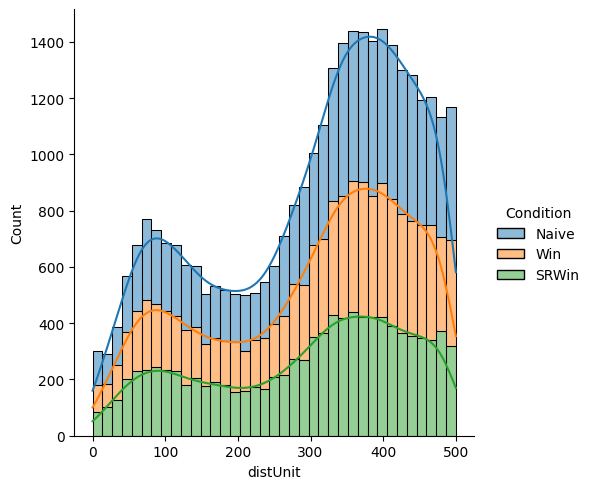

In [6]:
sns.displot(df, x="distUnit", hue="Condition", kde = True, multiple="stack", common_norm=False)

c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


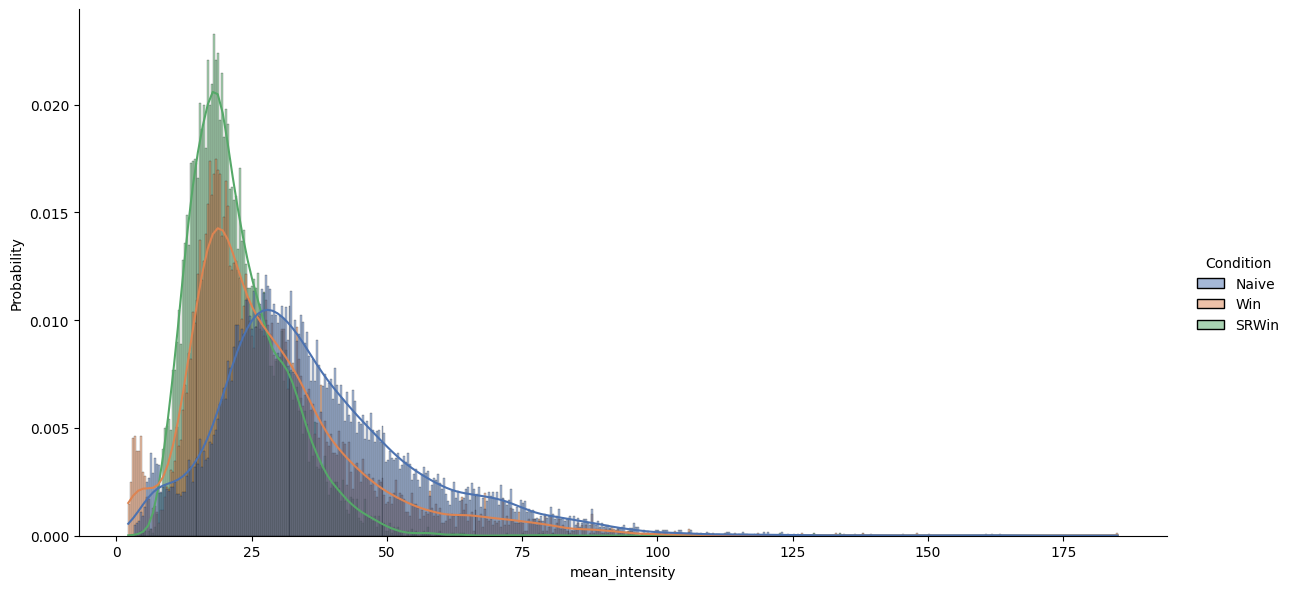

In [7]:
sns.displot(df, x="mean_intensity", hue="Condition", stat = 'probability', bins = 500, kde = True, palette = "deep",height=6, aspect=2, common_norm=False)

c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


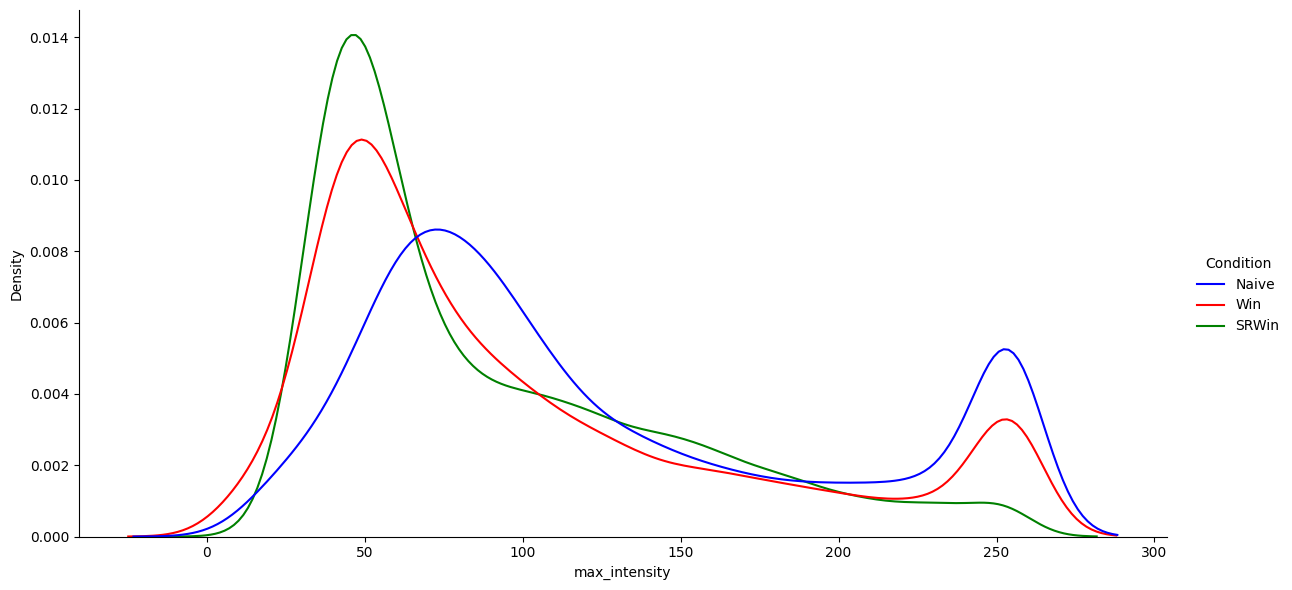

In [11]:
sns.displot(df, x="max_intensity", hue="Condition", kind = 'kde', palette={"Naive": "blue","Veh": "blue", "SRWin": "green", "Win": "red"},height=6, aspect=2, common_norm=False)


In [5]:
naive, srwin, win = extract_conditions(df)

In [7]:
naive.head()

Unnamed: 0                                       imageLabel_x  Label  \
0         355  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    926   
1         350  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    923   
2         317  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    854   
3         319  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    857   
4         334  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    888   

       distPix    distUnit  side       length     P1x     P1y     P2x  ...  \
0  1087.121480  339.141560     2  1931.026735  2833.5  2830.5  2491.5  ...   
1  1335.057486  416.488392     2  1931.026735  2833.5  2830.5  2491.5  ...   
2   512.481846  159.875318     2  1931.026735  2833.5  2830.5  2491.5  ...   
3   573.699497  178.972953     2  1931.026735  2833.5  2830.5  2491.5  ...   
4   276.004369   86.103121     2  1931.026735  2833.5  2830.5  2491.5  ...   

             ID  Condition  Sex  Figure        bins  index  Z-Section  \
0  B4PPGI2Naive      Naive    M       9  (270, 500]     87         18   
1  B4PPGI2Naive      Naive    M       9  (270, 500]     87         18   
2  B4PPGI2Naive      Naive    M       9  (120, 270]     87         18   
3  B4PPGI2Naive      Naive    M       9  (120, 270]     87         18   
4  B4PPGI2Naive      Naive    M       9    (0, 120]     87         18   

   PixelSize_Z  Height  volumic_density  
0         0.93   16.74          0.00712  
1         0.93   16.74          0.00712  
2         0.93   16.74          0.00712  
3         0.93   16.74          0.00712  
4         0.93   16.74          0.00712  

[5 rows x 33 columns]

C:\Windows\Temp\ipykernel_15296\290548940.py:1: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.displot(naive, x="max_intensity", hue="ID", kind = 'kde', palette = ["blue"],height=6, aspect=2, common_norm=False)
c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


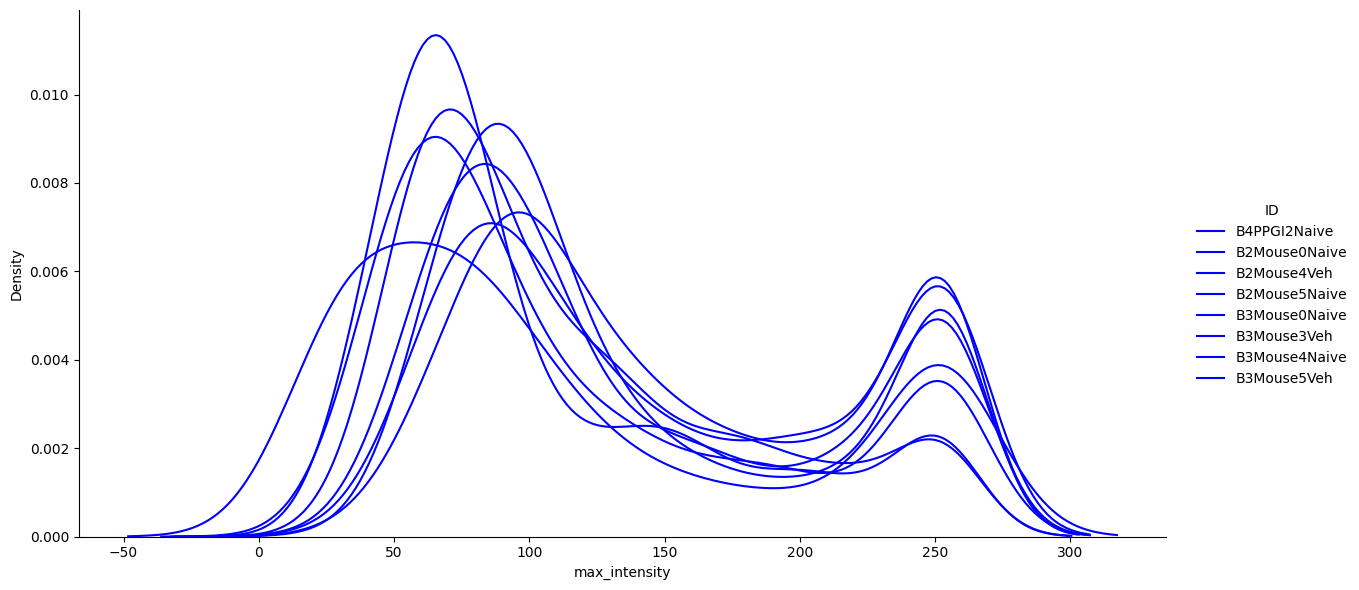

In [9]:
sns.displot(naive, x="max_intensity", hue="ID", kind = 'kde', palette = ["blue"],height=6, aspect=2, common_norm=False)


c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


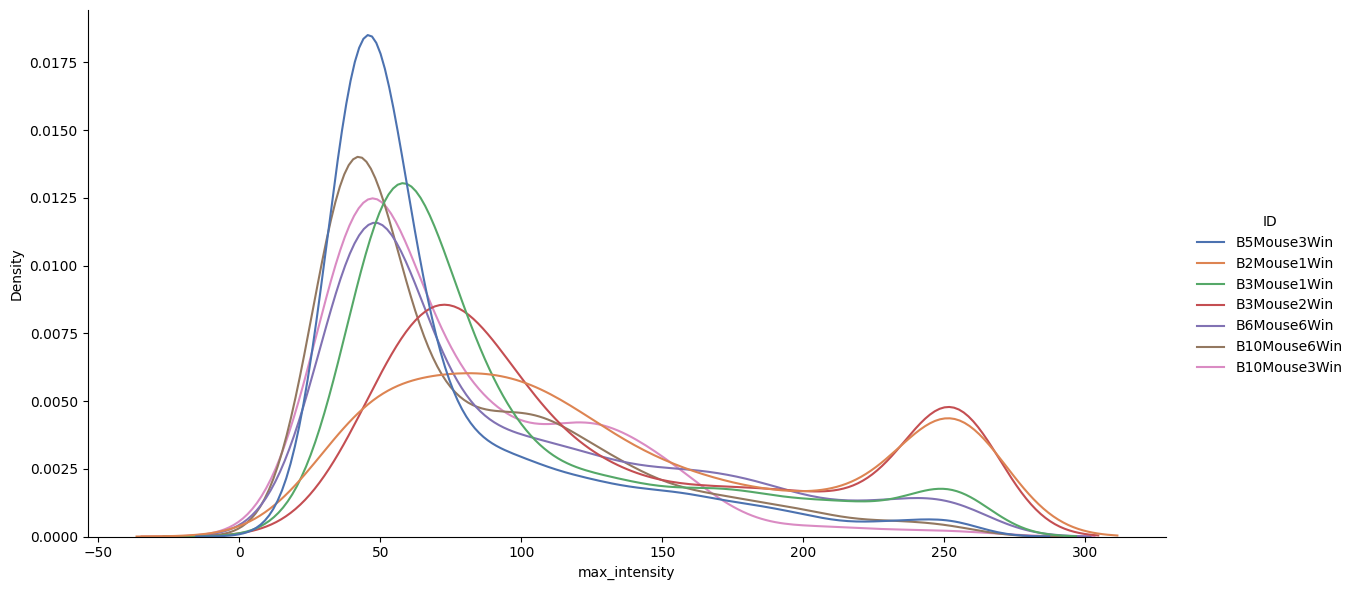

In [10]:
sns.displot(win, x="max_intensity", hue="ID", kind = 'kde', palette = "deep",height=6, aspect=2, common_norm=False)

c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


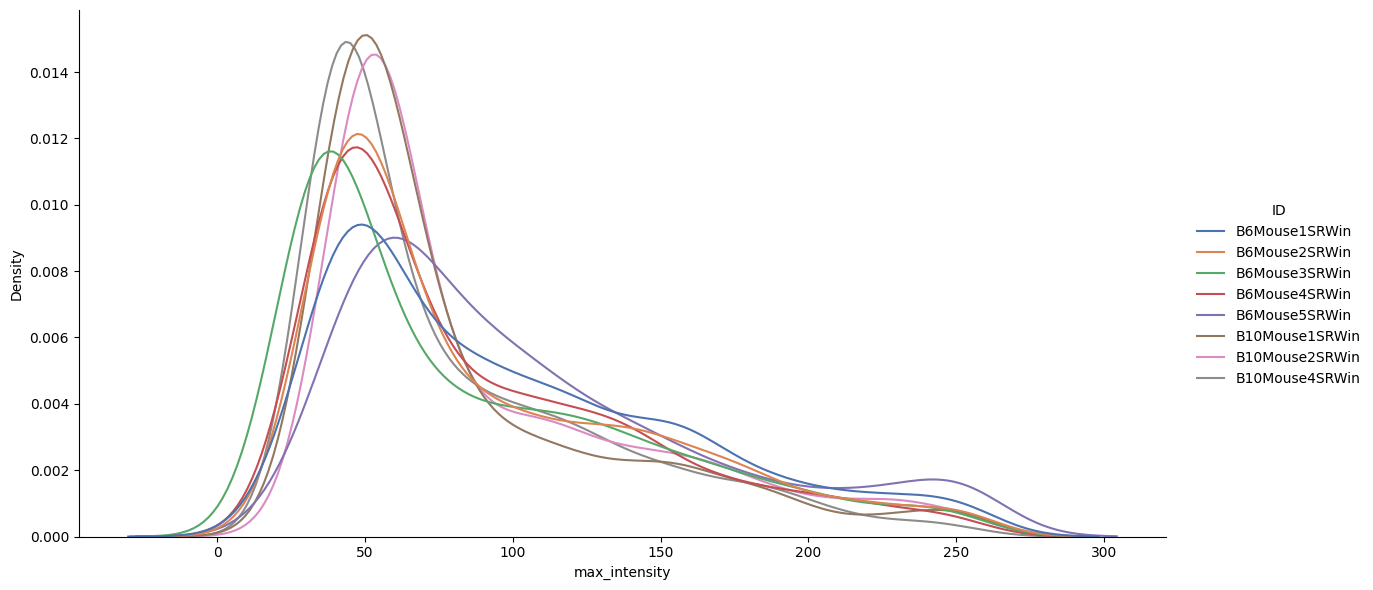

In [11]:
ax = sns.displot(srwin, x="max_intensity", hue="ID", kind = 'kde', palette = "deep",height=6, aspect=2, common_norm=False)

C:\Windows\Temp\ipykernel_15296\332917556.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  coords = np.vstack(map(np.ravel, grid))


In [15]:

def estimate_maxima(data):
    kde = gaussian_kde(data)
    no_samples = 10
    samples = np.linspace(min(data), max(data), no_samples)
    probs = kde.evaluate(samples)
    maxima_index = probs.argmax()
    maxima = samples[maxima_index]

    return maxima

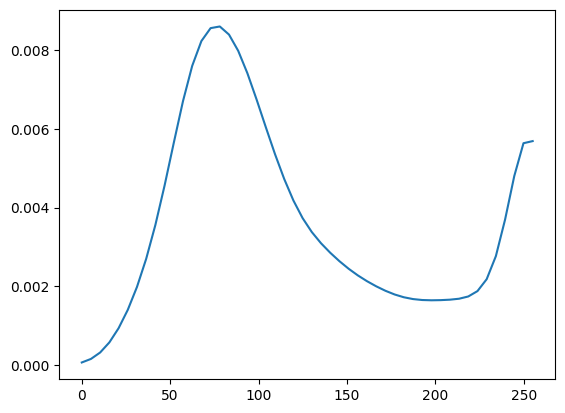

In [20]:

eval_points = np.linspace(0, 255)
kernel = gaussian_kde(naive['max_intensity'])
y_sp = kernel.pdf(eval_points)
plt.plot(eval_points, y_sp)


In [31]:
eval_points = np.linspace(0, 255)
kernel = gaussian_kde(naive['max_intensity'])
y_sp = kernel.pdf(eval_points)
plt.plot(eval_points, y_sp)

no_samples = 10
samples = np.linspace(0, 255, 100)
probs = kernel.evaluate(samples)
maxima_index = probs.argmax()
maxima = samples[maxima_index]
print(maxima)

77.27272727272727


In [38]:
for i in range(10):
    print(i)
    input("Press Enter to continue...")



0
1
2
3
4
5
6
7
8
9


First maximum: 69.54545454545455
treshold: 139.0909090909091


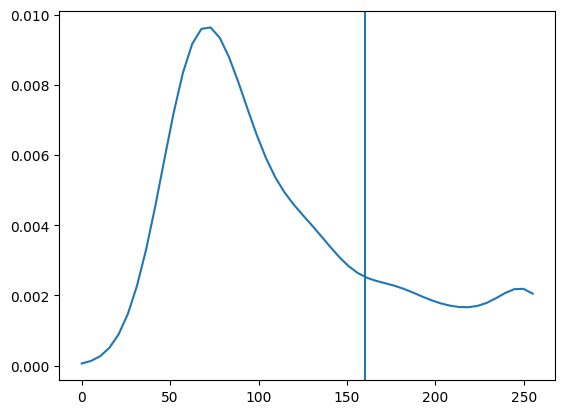

First maximum: 95.3030303030303
treshold: 190.6060606060606


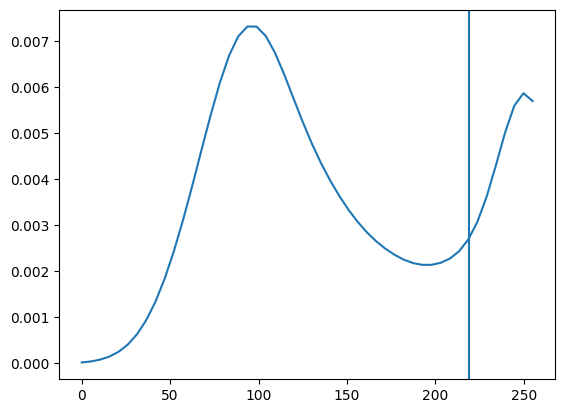

First maximum: 56.666666666666664
treshold: 113.33333333333333


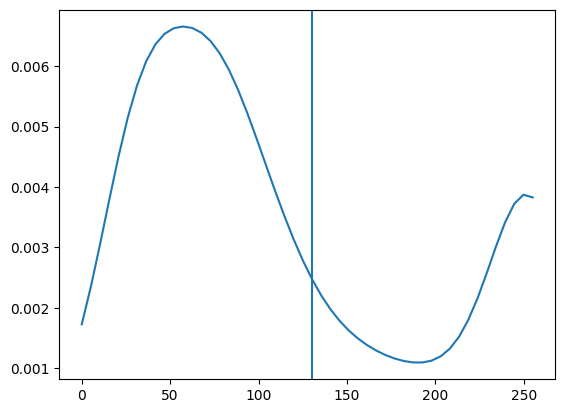

First maximum: 85.0
treshold: 170.0


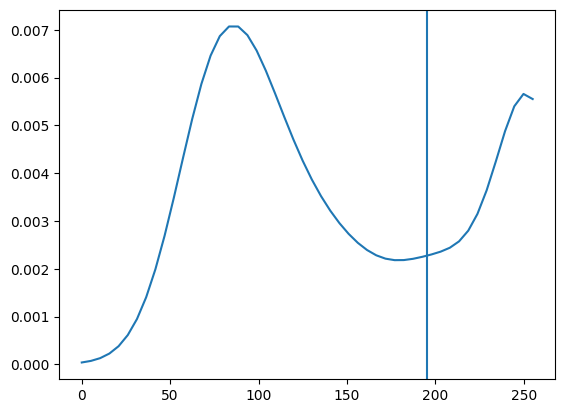

First maximum: 64.39393939393939
treshold: 128.78787878787878


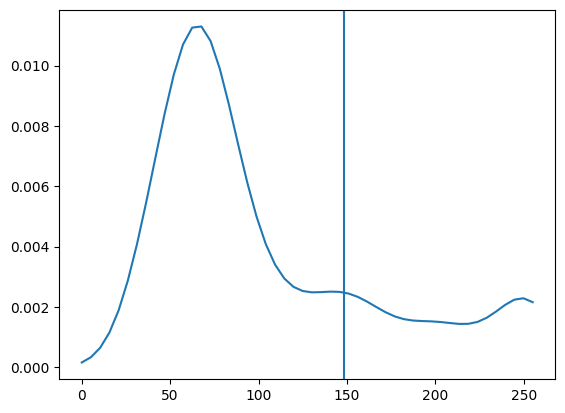

First maximum: 87.57575757575758
treshold: 175.15151515151516


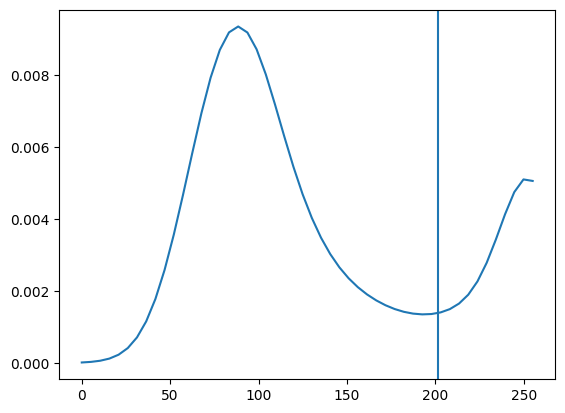

First maximum: 82.42424242424242
treshold: 164.84848484848484


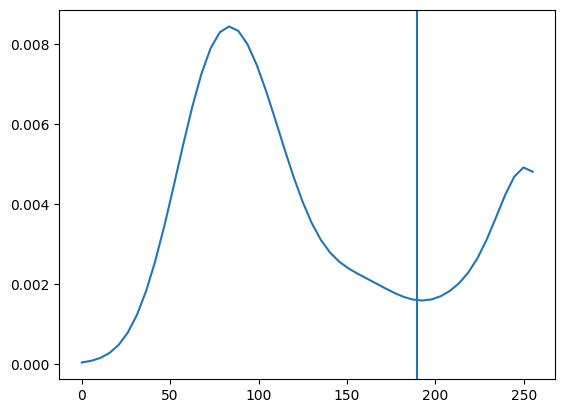

First maximum: 64.39393939393939
treshold: 128.78787878787878


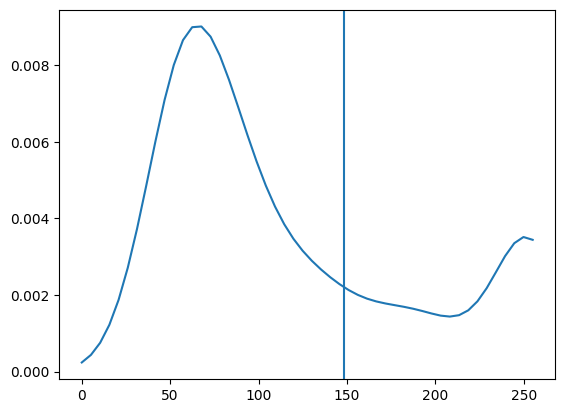

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
for id in naive['ID'].unique():
    # Generate data and compute KDE
    eval_points = np.linspace(0, 255)
    kernel = gaussian_kde(naive[naive['ID']==id]['max_intensity'])
    y_sp = kernel.pdf(eval_points)
    plt.plot(eval_points, y_sp)

    # Find first maximum
    no_samples = 10
    samples = np.linspace(0, 255, 100)
    probs = kernel.evaluate(samples)
    maxima_index = probs.argmax()
    first_maxima = samples[maxima_index]

    # Set a threshold
    threshold = 2*first_maxima
      # Assuming a significant difference between maxima

    # Filter out values below the threshold
    samples_filtered = samples[samples > threshold]
    probs_filtered = kernel.evaluate(samples_filtered)

    # Find second maximum
    second_maxima_index = probs_filtered.argmax()
    second_maxima = samples_filtered[second_maxima_index]

    print("First maximum:", first_maxima)
    print("treshold:", 2*first_maxima)
    plt.axvline(x = 2.3
                *first_maxima)
    plt.show()
    #input("Press Enter to continue...")
    




c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


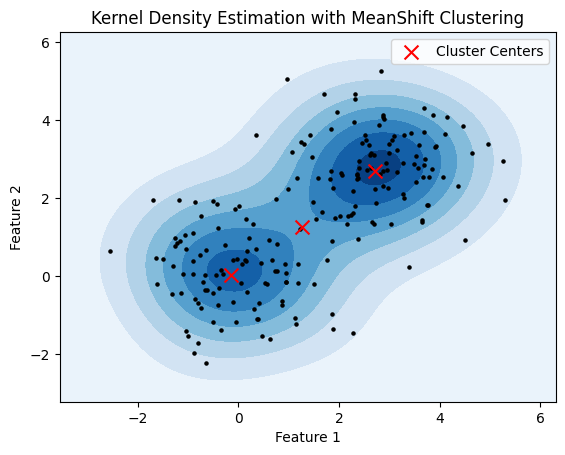

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.neighbors import KernelDensity

# Generate sample data (2D)
np.random.seed(0)
data = np.vstack([np.random.normal(loc=0, scale=1, size=(100, 2)),
                  np.random.normal(loc=3, scale=1, size=(100, 2))])

# Fit MeanShift clustering to find clusters
ms = MeanShift()
ms.fit(data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Perform KDE on the data
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(data)

# Evaluate the KDE on a grid
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the KDE result
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], s=5, color='black')

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, color='red', label='Cluster Centers')

plt.title('Kernel Density Estimation with MeanShift Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()



### Volumic density

In [12]:
layer1_a = pd.DataFrame(a.groupby(['ID', 'Condition'])['volumic_density_layer1'].mean()).reset_index()
layer1_a.head()

ID Condition  volumic_density_layer1
0  B10Mouse1SRWin     SRWin               28.311804
1  B10Mouse2SRWin     SRWin               27.278948
2    B10Mouse3Win       Win               29.843267
3  B10Mouse4SRWin     SRWin               20.981705
4    B10Mouse6Win       Win               24.784065

In [13]:
layer23_a = pd.DataFrame(a.groupby(['ID', 'Condition'])['volumic_density_layer23'].mean()).reset_index()
layer23_a.head()

ID Condition  volumic_density_layer23
0  B10Mouse1SRWin     SRWin                27.653279
1  B10Mouse2SRWin     SRWin                28.152562
2    B10Mouse3Win       Win                14.921633
3  B10Mouse4SRWin     SRWin                20.884682
4    B10Mouse6Win       Win                23.873026

In [14]:
layer56_a = pd.DataFrame(a.groupby(['ID', 'Condition'])['volumic_density_layer56'].mean()).reset_index()
layer56_a.head()

ID Condition  volumic_density_layer56
0  B10Mouse1SRWin     SRWin                68.174322
1  B10Mouse2SRWin     SRWin                63.121746
2    B10Mouse3Win       Win                40.483040
3  B10Mouse4SRWin     SRWin                48.125835
4    B10Mouse6Win       Win                41.498877

Text(0.5, 1.0, 'Layer 5 and 6')

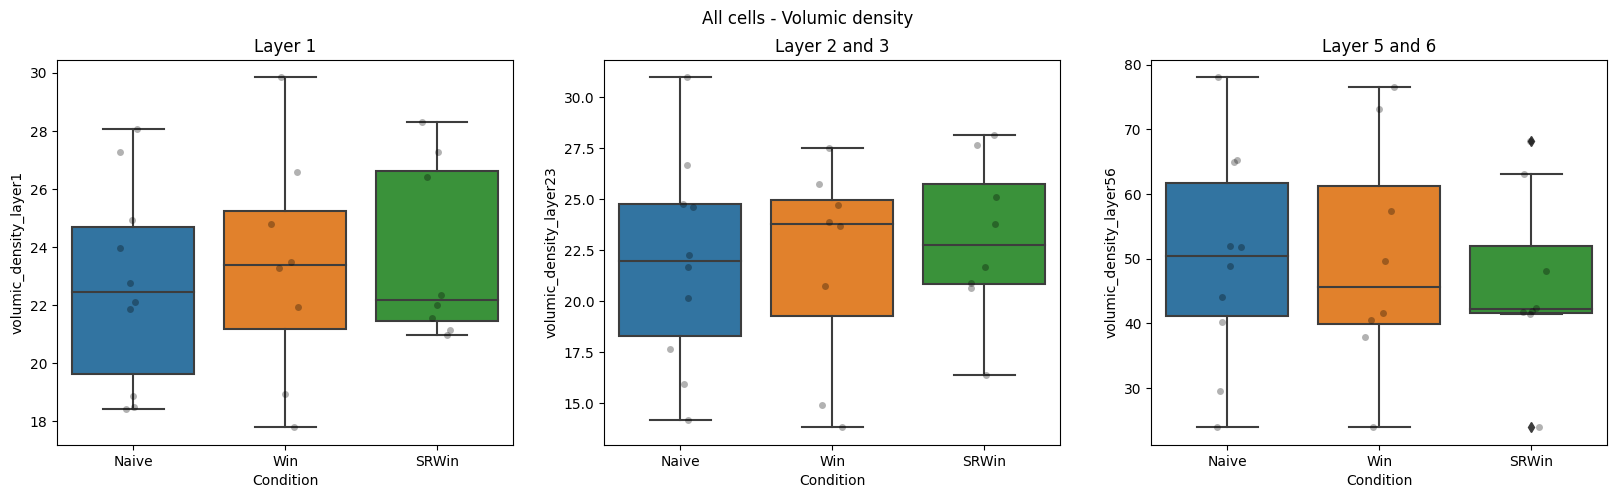

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('All cells - Volumic density')
sns.boxplot(layer1_a, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer1_a,
              ax=axes[0])
axes[0].set_title('Layer 1')
sns.boxplot(layer23_a, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer23_a,
              ax=axes[1])
axes[1].set_title('Layer 2 and 3')
sns.boxplot(layer56_a, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[2])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer56_a,
              ax=axes[2])
axes[2].set_title('Layer 5 and 6')


#### Bregma coordinates

In [203]:
fig910_a = a[(a['Figure']==9) | (a['Figure']==10)]
fig910_a = pd.DataFrame(fig910_a.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig910_a.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              56.082099
1  B10Mouse2SRWin     SRWin              53.177883
2    B10Mouse3Win       Win              30.261072
3  B10Mouse4SRWin     SRWin              36.472752
4    B10Mouse6Win       Win              30.198288

In [204]:
fig1112_a = a[(a['Figure']==11) | (a['Figure']==12)]
fig1112_a = pd.DataFrame(fig1112_a.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1112_a.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              44.573271
1  B10Mouse2SRWin     SRWin              44.247357
2  B10Mouse4SRWin     SRWin              33.818164
3    B10Mouse6Win       Win              36.487237
4   B2Mouse0Naive     Naive              34.747724

In [205]:
fig13_a = a[(a['Figure']==13) ]
fig13_a = pd.DataFrame(fig13_a.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig13_a.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              36.754825
1  B10Mouse2SRWin     SRWin              39.971468
2  B10Mouse4SRWin     SRWin              37.182372
3    B10Mouse6Win       Win              26.658446
4   B2Mouse0Naive     Naive              27.488474

In [206]:
fig1415_a = a[(a['Figure']==14) | (a['Figure']==15)]
fig1415_a = pd.DataFrame(fig1415_a.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1415_a.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              43.545733
1  B10Mouse2SRWin     SRWin              36.689544
2  B10Mouse4SRWin     SRWin              27.964408
3    B10Mouse6Win       Win              32.683737
4   B2Mouse0Naive     Naive              35.894565

Text(0.5, 1.0, 'Figure 14 and 15')

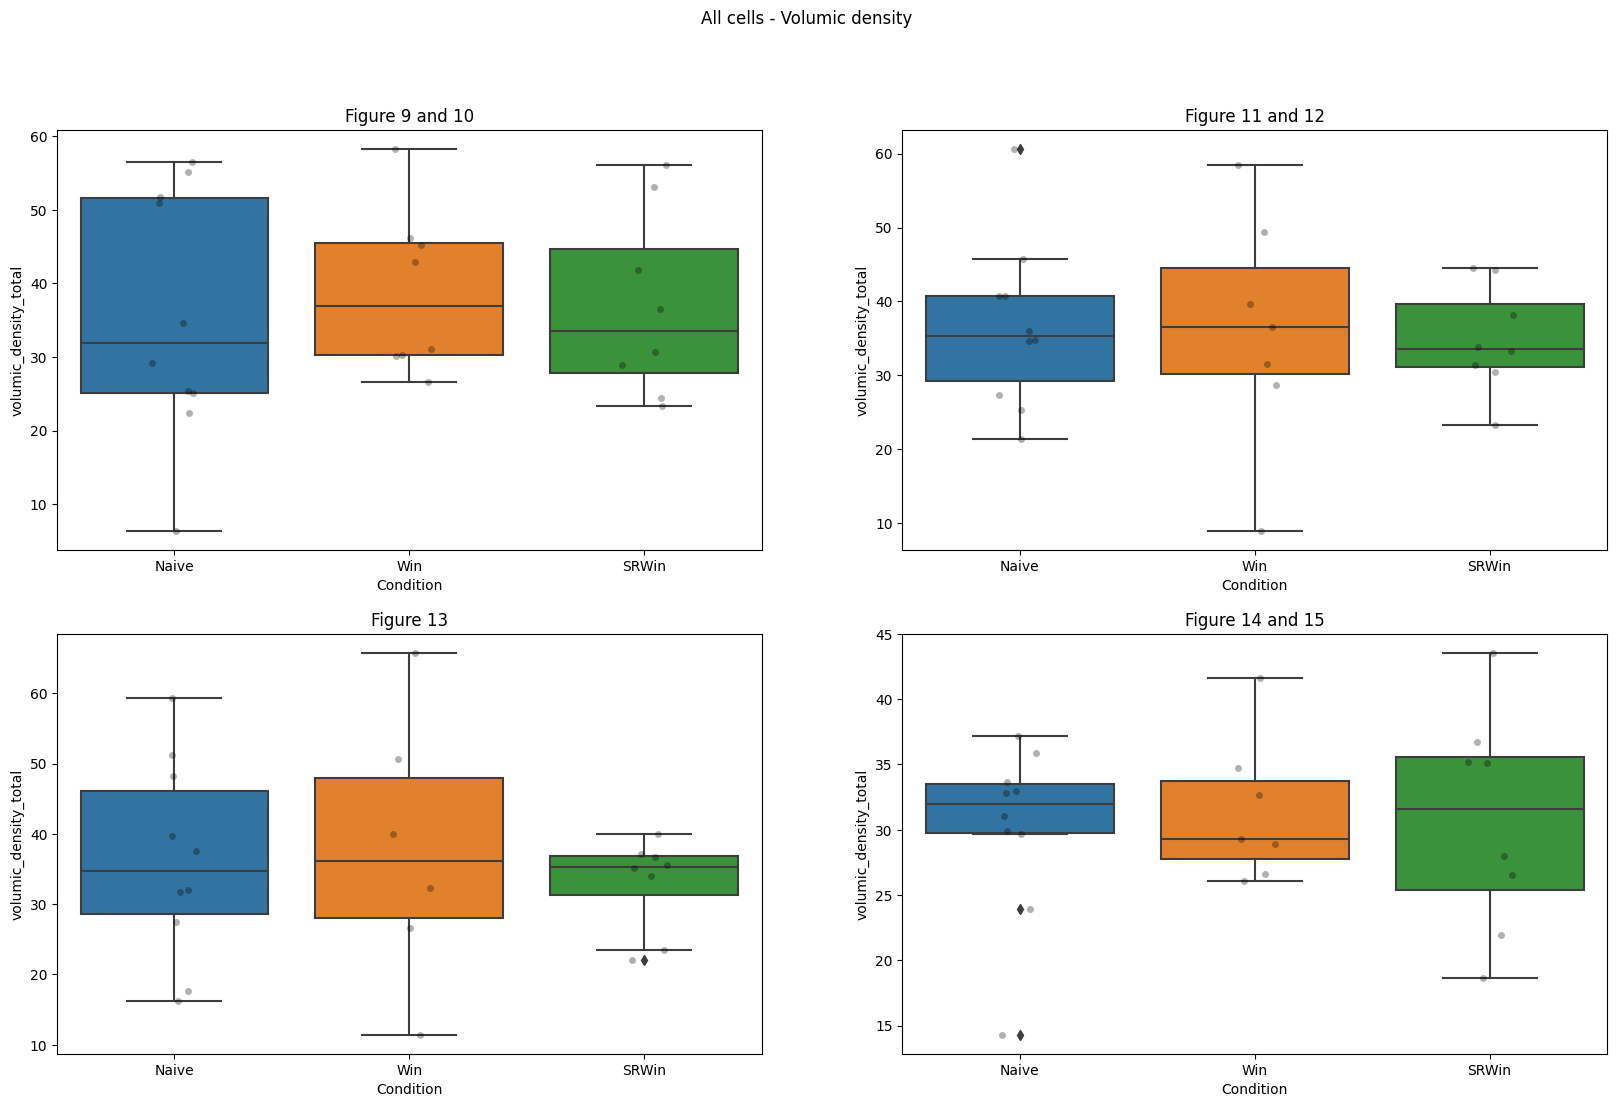

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle('All cells - Volumic density')
sns.boxplot(fig910_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910_a,
              ax=axes[0, 0])
axes[0, 0].set_title('Figure 9 and 10')
sns.boxplot(fig1112_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112_a,
              ax=axes[0, 1])
axes[0,1].set_title('Figure 11 and 12')
sns.boxplot(fig13_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13_a,
              ax=axes[1, 0])
axes[1, 0].set_title('Figure 13')
sns.boxplot(fig1415_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415_a,
              ax=axes[1,1])
axes[1,1].set_title('Figure 14 and 15')

### Carefull : Without grouping by animal 

Text(0.5, 1.0, 'Volumic density - Layer 5 and 6')

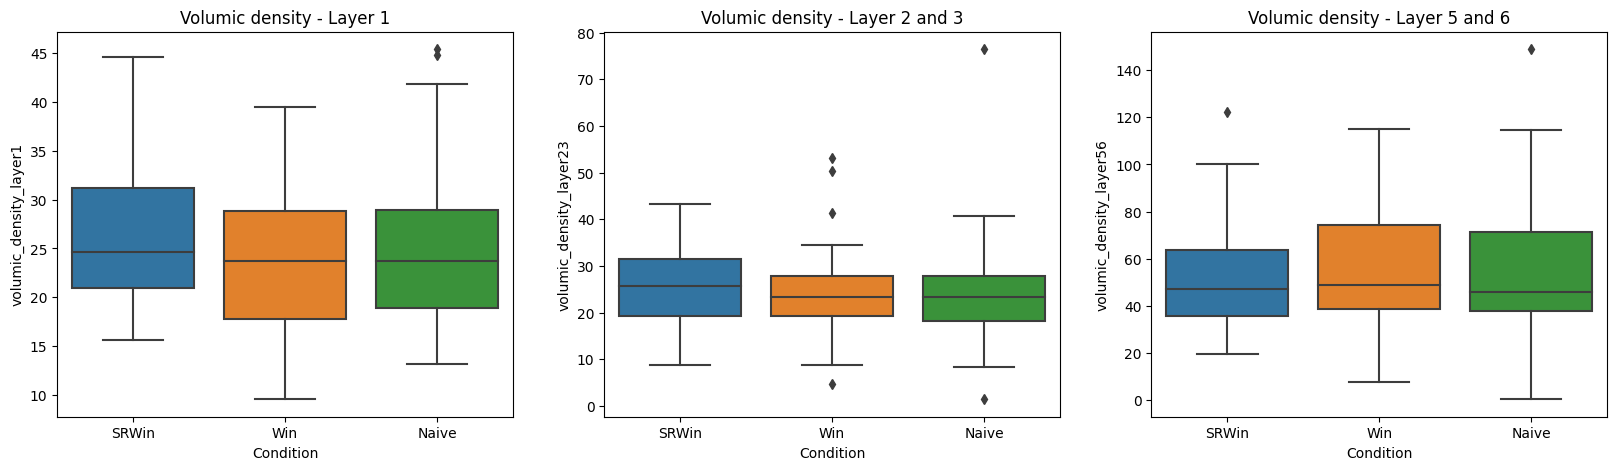

In [293]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(a, y='volumic_density_layer1', x = 'Condition', ax=axes[0])
axes[0].set_title('Volumic density - Layer 1')
sns.boxplot(a, y='volumic_density_layer23', x = 'Condition', ax=axes[1])
axes[1].set_title('Volumic density - Layer 2 and 3')
sns.boxplot(a, y='volumic_density_layer56', x = 'Condition', ax=axes[2])
axes[2].set_title('Volumic density - Layer 5 and 6')



# Cytoplasmic and binding reelin distinction

In [7]:
cytoplasmic = df.loc[df['max_intensity']>150].copy()
binding = df.loc[df['max_intensity']<=150].copy()

## Cytoplasmic

### Distance density

In [5]:
cytoplasmic.head()

Unnamed: 0                                       imageLabel_x  Label  \
137         343  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    901   
202         270  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    735   
209         304  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    819   
212          77  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...    217   
215           0  191001_B4_PPGI2_Naive_P35_M_C57_Rln_PFC1_FIG9_...     50   

        distPix    distUnit  side       length     P1x     P1y     P2x  ...  \
137  246.280422   76.830352     2  1931.026735  2833.5  2830.5  2491.5  ...   
202  546.663060  170.538588     2  1931.026735  2833.5  2830.5  2491.5  ...   
209  164.339313   51.267767     2  1931.026735  2833.5  2830.5  2491.5  ...   
212  260.527841   81.275018     2  1931.026735  2833.5  2830.5  2491.5  ...   
215  216.870630   67.655588     2  1931.026735  2833.5  2830.5  2491.5  ...   

               ID  Condition  Sex  Figure        bins  index  Z-Section  \
137  B4PPGI2Naive      Naive    M       9    (0, 120]     87         18   
202  B4PPGI2Naive      Naive    M       9  (120, 270]     87         18   
209  B4PPGI2Naive      Naive    M       9    (0, 120]     87         18   
212  B4PPGI2Naive      Naive    M       9    (0, 120]     87         18   
215  B4PPGI2Naive      Naive    M       9    (0, 120]     87         18   

     PixelSize_Z  Height  volumic_density  
137         0.93   16.74          0.00712  
202         0.93   16.74          0.00712  
209         0.93   16.74          0.00712  
212         0.93   16.74          0.00712  
215         0.93   16.74          0.00712  

[5 rows x 33 columns]

In [17]:
grouped_counts = cytoplasmic.groupby(['ID', 'Figure']).size()


In [18]:
grouped_counts2 = binding.groupby(['ID', 'Figure']).size()

In [19]:
bbb = grouped_counts2.to_frame()

In [13]:
aaa = grouped_counts.to_frame()

In [20]:
bbb['bind'] = 'bind'

In [21]:
ccc = pd.merge(aaa, bbb, how = 'outer', on=['ID', 'Figure'])

In [22]:
ccc.to_csv

0_x  cyto  0_y  bind
ID             Figure                       
B10Mouse1SRWin 9       25.0  cyto  160  bind
               10      26.0  cyto  194  bind
               11      41.0  cyto  249  bind
               12      27.0  cyto  179  bind
               13      14.0  cyto  152  bind
...                     ...   ...  ...   ...
B2Mouse3Win    13       NaN   NaN   91  bind
B2Mouse4Veh    10       NaN   NaN  145  bind
               12       NaN   NaN  134  bind
B5Mouse5Naive  13       NaN   NaN   88  bind
               14       NaN   NaN  120  bind

[156 rows x 4 columns]

In [16]:
aaa

0  cyto
ID             Figure          
B10Mouse1SRWin 9       25  cyto
               10      26  cyto
               11      41  cyto
               12      27  cyto
               13      14  cyto
...                    ..   ...
B6Mouse6Win    10      35  cyto
               11      44  cyto
               12      59  cyto
               14      29  cyto
               15      29  cyto

[146 rows x 2 columns]

In [23]:
ccc.to_csv(r"C:\Users\Thenzing\Downloads\cyto_count2.csv")

c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


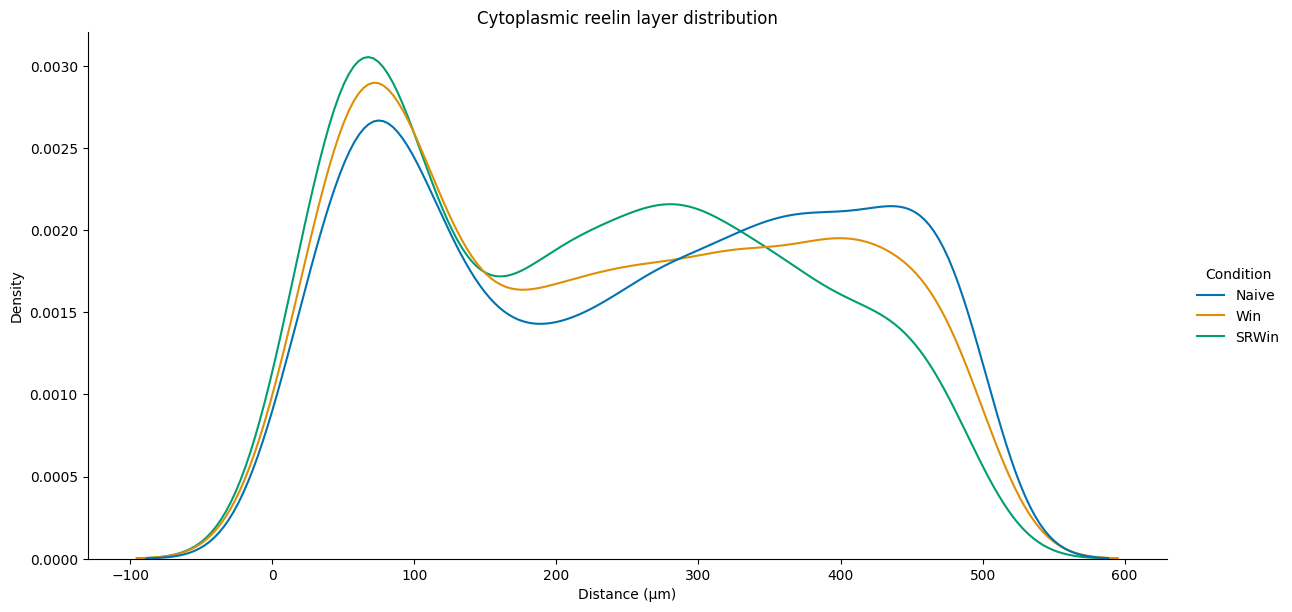

In [135]:
sns.displot(cytoplasmic, x="distUnit", hue="Condition", kind = 'kde', palette = "colorblind",height=6, aspect=2, common_norm=False).set(title='Cytoplasmic reelin layer distribution',xlabel ="Distance (µm)", ylabel = "Density")


c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



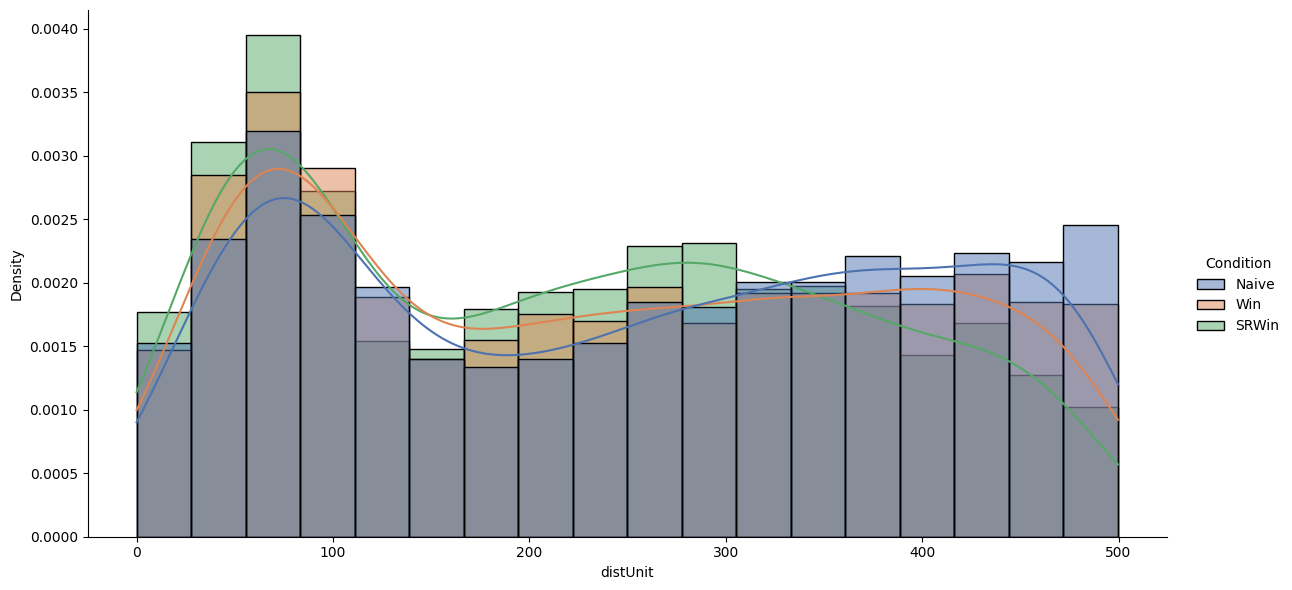

In [296]:
sns.displot(cytoplasmic, x="distUnit", hue="Condition", stat = 'density', kde  =True, palette = "deep",height=6, aspect=2, common_norm=False)

### Volumic density

#### Data vizualization

In [8]:
c = cytoplasmic.groupby(['ID', 'Figure','Condition', 'Height', 'length','bins'])['bins'].count()
c.to_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
#passage par csv pour régler problème de mise en page
c = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
c = c.pivot_table(
    index = ['ID', 'Figure','Condition', 'Height','length'], 
    columns = 'bins', 
    values = 'bins').reset_index()
c['volumic_density_layer1'] = c['(0, 120]']/(120*c['length']*pix_to_micron*c['Height'])*1000000 #unit is a 100µm cube
c['volumic_density_layer23'] = c['(120, 270]']/(150*c['length']*pix_to_micron*c['Height'])*1000000 #unit is a 100µm cube
c['volumic_density_layer56'] = c['(270, 500]']/(230*c['length']*pix_to_micron*c['Height'])*1000000 #unit is a 100µm cube
c['volumic_density_total'] = (c['(270, 500]']+ c['(120, 270]']+c['(0, 120]'])/(500*c['length']*pix_to_micron*c['Height'])*1000000 #unit is a 100µm cube


In [96]:
c.head()

bins              ID  Figure Condition  Height       length  (0, 120]  \
0     B10Mouse1SRWin       9     SRWin   16.38  1611.700112       6.0   
1     B10Mouse1SRWin      10     SRWin   15.84  1324.281881       7.0   
2     B10Mouse1SRWin      11     SRWin   19.26  1929.029030       6.0   
3     B10Mouse1SRWin      12     SRWin   17.64  1914.531601       9.0   
4     B10Mouse1SRWin      13     SRWin   18.00  1608.600790       5.0   

bins  (120, 270]  (270, 500]  volumic_density_layer1  volumic_density_layer23  \
0            9.0        10.0                6.071122                 7.285346   
1            3.0        16.0                8.914115                 3.056268   
2           14.0        21.0                4.313919                 8.052649   
3            6.0        12.0                7.118643                 3.796610   
4            4.0         5.0                4.612804                 2.952195   

bins  volumic_density_layer56  volumic_density_total  
0                    5.279236               6.071122  
1                   10.630498               7.946297  
2                    7.877592               7.074828  
3                    4.952099               5.125423  
4                    2.406681               3.099805

#### Computing descriptive info per animal and layer

In [9]:
layer1_c = pd.DataFrame(c.groupby(['ID', 'Condition'])['volumic_density_layer1'].mean()).reset_index()
layer1_c.head()

ID Condition  volumic_density_layer1
0  B10Mouse1SRWin     SRWin                8.694685
1  B10Mouse2SRWin     SRWin               10.021074
2    B10Mouse3Win       Win                     NaN
3  B10Mouse4SRWin     SRWin                6.263668
4    B10Mouse6Win       Win                6.524629

In [10]:
layer23_c = pd.DataFrame(c.groupby(['ID', 'Condition'])['volumic_density_layer23'].mean()).reset_index()
layer23_c.head()

ID Condition  volumic_density_layer23
0  B10Mouse1SRWin     SRWin                 5.616198
1  B10Mouse2SRWin     SRWin                 6.747054
2    B10Mouse3Win       Win                 1.193731
3  B10Mouse4SRWin     SRWin                 3.758206
4    B10Mouse6Win       Win                 3.036405

In [11]:
layer56_c = pd.DataFrame(c.groupby(['ID', 'Condition'])['volumic_density_layer56'].mean()).reset_index()
layer56_c.head()

ID Condition  volumic_density_layer56
0  B10Mouse1SRWin     SRWin                 5.523982
1  B10Mouse2SRWin     SRWin                 5.825572
2    B10Mouse3Win       Win                 3.892600
3  B10Mouse4SRWin     SRWin                 3.166156
4    B10Mouse6Win       Win                 2.603408

#### Plots per layer (1 point is mean per animal)

Text(0.5, 1.0, 'Layer 5 and 6')

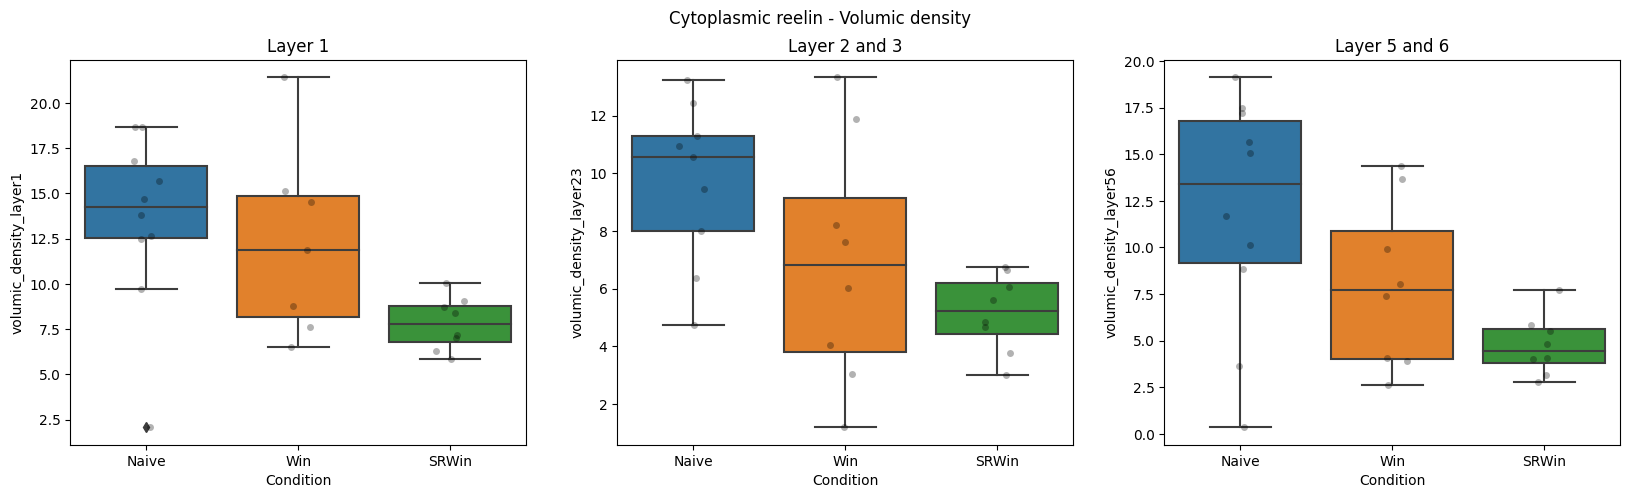

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Cytoplasmic reelin - Volumic density')
sns.boxplot(layer1_c, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer1_c,
              ax=axes[0])
axes[0].set_title('Layer 1')
sns.boxplot(layer23_c, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer23_c,
              ax=axes[1])
axes[1].set_title('Layer 2 and 3')
sns.boxplot(layer56_c, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[2])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer56_c,
              ax=axes[2])
axes[2].set_title('Layer 5 and 6')


#### Bregma coordinates

In [195]:
fig910 = c[(c['Figure']==9) | (c['Figure']==10)]
fig910 = pd.DataFrame(fig910.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig910.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin               7.008709
1  B10Mouse2SRWin     SRWin               5.416218
2    B10Mouse3Win       Win                    NaN
3  B10Mouse4SRWin     SRWin               3.302901
4    B10Mouse6Win       Win               3.153881

In [196]:
fig1112 = c[(c['Figure']==11) | (c['Figure']==12)]
fig1112 = pd.DataFrame(fig1112.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1112.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin               6.100125
1  B10Mouse2SRWin     SRWin               7.250616
2  B10Mouse4SRWin     SRWin               3.321914
3    B10Mouse6Win       Win               2.621820
4   B2Mouse0Naive     Naive              16.662996

In [197]:
fig13 = c[(c['Figure']==13) ]
fig13 = pd.DataFrame(fig13.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig13.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin               3.099805
1  B10Mouse2SRWin     SRWin               8.126068
2  B10Mouse4SRWin     SRWin               5.668045
3    B10Mouse6Win       Win               1.269450
4   B2Mouse0Naive     Naive              14.350600

In [198]:
fig1415 = c[(c['Figure']==14) | (c['Figure']==15)]
fig1415 = pd.DataFrame(fig1415.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1415.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin               7.435418
1  B10Mouse2SRWin     SRWin               8.151413
2  B10Mouse4SRWin     SRWin               5.228901
3    B10Mouse6Win       Win               6.449975
4   B2Mouse0Naive     Naive              14.243773

Text(0.5, 1.0, 'Figure 14 and 15')

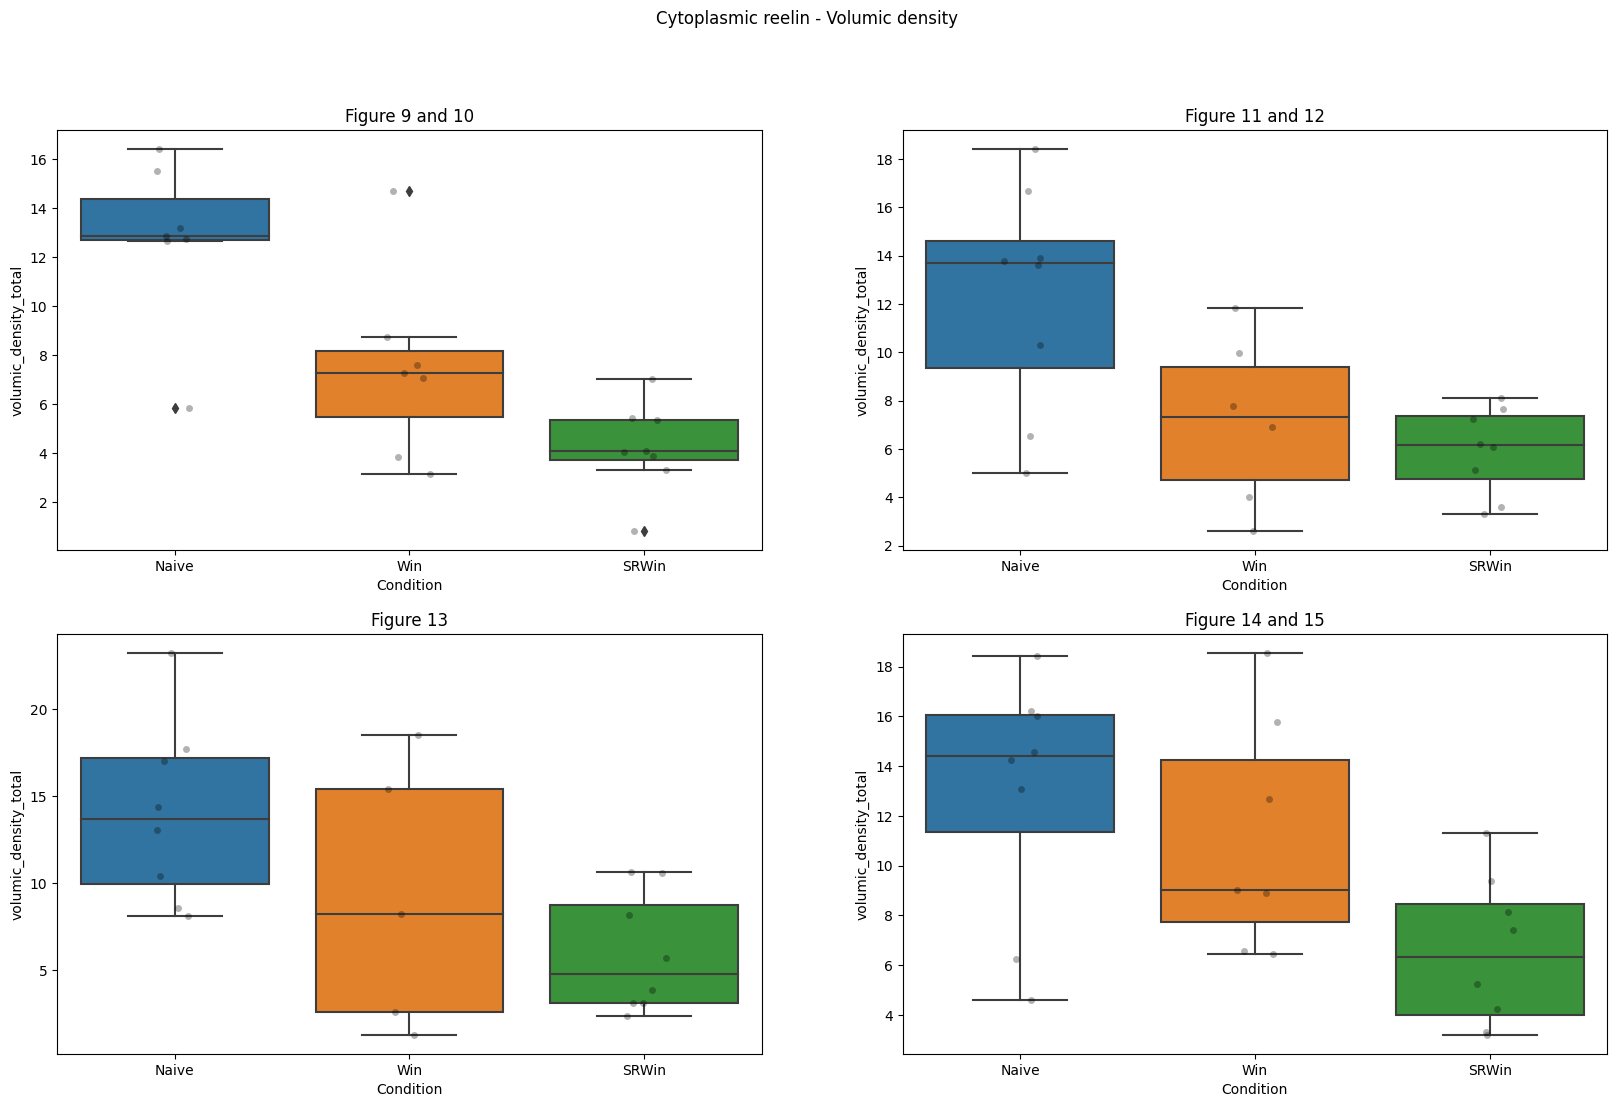

In [199]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle('Cytoplasmic reelin - Volumic density')
sns.boxplot(fig910, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910,
              ax=axes[0, 0])
axes[0, 0].set_title('Figure 9 and 10')
sns.boxplot(fig1112, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112,
              ax=axes[0, 1])
axes[0,1].set_title('Figure 11 and 12')
sns.boxplot(fig13, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13,
              ax=axes[1, 0])
axes[1, 0].set_title('Figure 13')
sns.boxplot(fig1415, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415,
              ax=axes[1,1])
axes[1,1].set_title('Figure 14 and 15')

### Carefull : Without grouping by animal 

Text(0.5, 1.0, 'Layer 5 and 6')

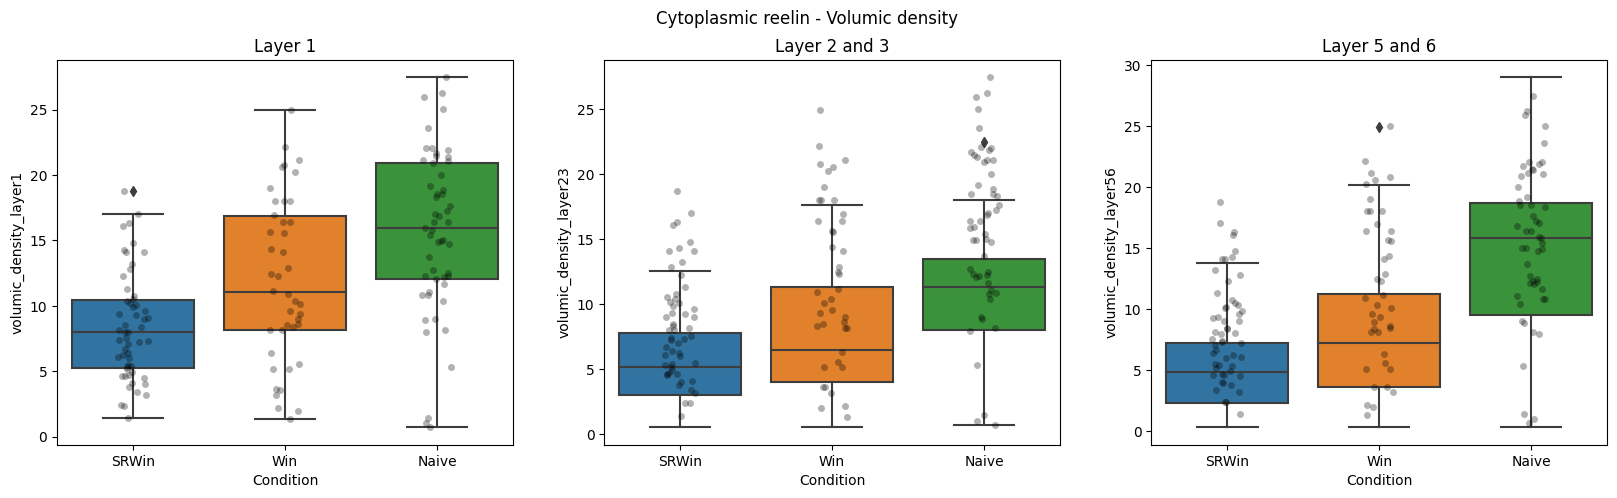

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Cytoplasmic reelin - Volumic density')
sns.boxplot(c, y='volumic_density_layer1', x = 'Condition', ax=axes[0])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              color = 'black',
              alpha = 0.3,
              data = c,
              ax=axes[0])
axes[0].set_title('Layer 1')
sns.boxplot(c, y='volumic_density_layer23', x = 'Condition', ax=axes[1])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              color = 'black',
              alpha = 0.3,
              data = c,
              ax=axes[1])
axes[1].set_title('Layer 2 and 3')
sns.boxplot(c, y='volumic_density_layer56', x = 'Condition', ax=axes[2])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              color = 'black',
              alpha = 0.3,
              data = c,
              ax=axes[2])
axes[2].set_title('Layer 5 and 6')


### 3D Plots

In [337]:
naivec, srwinc, winc = extract_conditions(cytoplasmic)

In [336]:
displot_3D(naivec, 'naive cytoplasmic')

In [335]:
displot_3D(srwinc, 'srwin cytoplasmic')

In [203]:
displot_3D(winc, 'win cytoplasmic')

### Joint Plots

#### distance + intensity

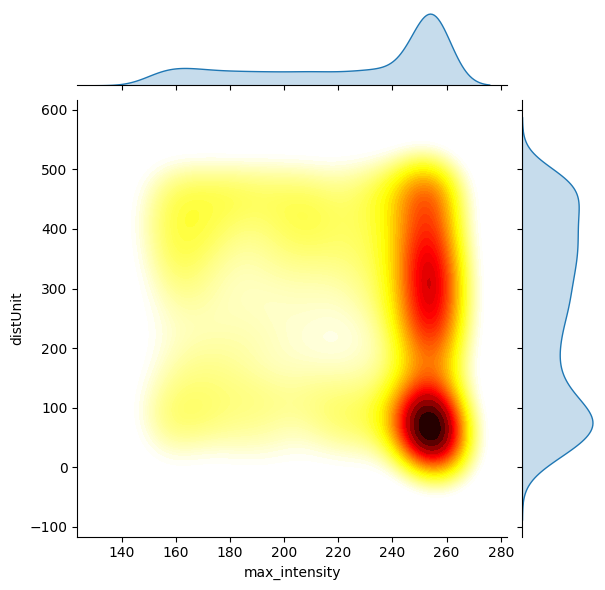

In [249]:
sns.jointplot(
    data=naivec,
    x="max_intensity", y="distUnit",cmap='hot_r', n_levels=60,
    kind="kde", fill=True)

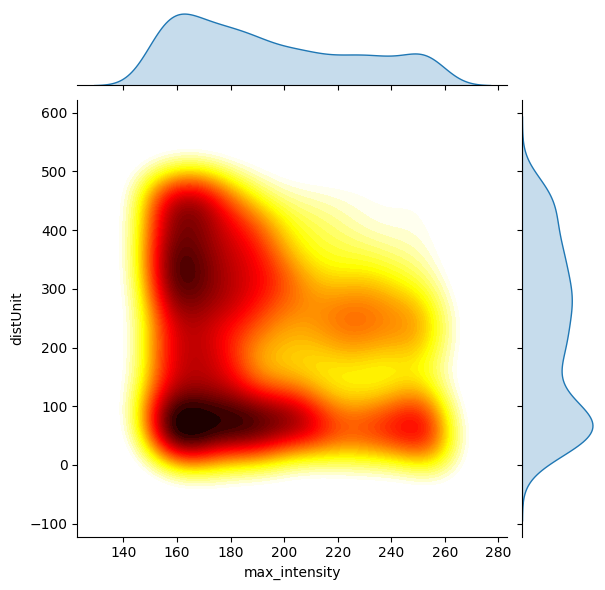

In [248]:
sns.jointplot(
    data=srwinc,
    x="max_intensity", y="distUnit",cmap='hot_r', n_levels=60,
    kind="kde", fill=True)

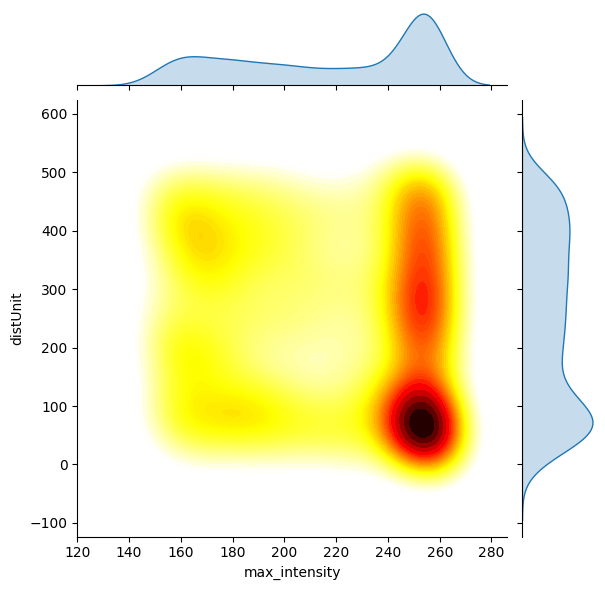

In [247]:
sns.jointplot(
    data=winc,
    x="max_intensity", y="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

## Binding

### Volumic density

#### Data vizualization

In [16]:
b = binding.groupby(['ID', 'Figure','Condition', 'Height', 'length','bins'])['bins'].count()
b.to_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
b = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
b = b.pivot_table(
    index = ['ID', 'Figure','Condition', 'Height', 'length'], 
    columns = 'bins', 
    values = 'bins').reset_index()
b['volumic_density_layer1'] = b['(0, 120]']/(120*b['length']*pix_to_micron*b['Height'])*1000000 #unit is a 100µm cube
b['volumic_density_layer23'] = b['(120, 270]']/(150*b['length']*pix_to_micron*b['Height'])*1000000 #unit is a 100µm cube
b['volumic_density_layer56'] = b['(270, 500]']/(230*b['length']*pix_to_micron*b['Height'])*1000000 #unit is a 100µm cube
b['volumic_density_total'] = (b['(270, 500]']+b['(120, 270]']+b['(0, 120]'])/(500*b['length']*pix_to_micron*b['Height'])*1000000 #unit is a 100µm cube

In [109]:
b.head()

bins              ID  Figure Condition  Height       length  (0, 120]  \
0     B10Mouse1SRWin       9     SRWin   16.38  1611.700112      26.0   
1     B10Mouse1SRWin      10     SRWin   15.84  1324.281881      15.0   
2     B10Mouse1SRWin      11     SRWin   19.26  1929.029030      21.0   
3     B10Mouse1SRWin      12     SRWin   17.64  1914.531601      18.0   
4     B10Mouse1SRWin      13     SRWin   18.00  1608.600790      21.0   

bins  (120, 270]  (270, 500]  volumic_density_layer1  volumic_density_layer23  \
0           33.0       101.0               26.308194                26.712935   
1           18.0       161.0               19.101675                18.337608   
2           27.0       201.0               15.098718                15.530110   
3           20.0       141.0               14.237286                12.655365   
4           33.0        98.0               19.373778                24.355607   

bins  volumic_density_layer56  volumic_density_total  
0                   53.320286              38.855179  
1                  106.969383              59.291601  
2                   75.399808              42.966637  
3                   58.187168              33.979655  
4                   47.170939              33.655021

#### Computing descriptive info per animal and layer

In [17]:
layer1_b = pd.DataFrame(b.groupby(['ID', 'Condition'])['volumic_density_layer1'].mean()).reset_index()
layer1_b.head()

ID Condition  volumic_density_layer1
0  B10Mouse1SRWin     SRWin               19.617119
1  B10Mouse2SRWin     SRWin               17.257875
2    B10Mouse3Win       Win               29.843267
3  B10Mouse4SRWin     SRWin               14.718037
4    B10Mouse6Win       Win               18.259436

In [18]:
layer23_b = pd.DataFrame(b.groupby(['ID', 'Condition'])['volumic_density_layer23'].mean()).reset_index()
layer23_b.head()

ID Condition  volumic_density_layer23
0  B10Mouse1SRWin     SRWin                22.037081
1  B10Mouse2SRWin     SRWin                21.405508
2    B10Mouse3Win       Win                13.727903
3  B10Mouse4SRWin     SRWin                17.126476
4    B10Mouse6Win       Win                20.836621

In [19]:
layer56_b = pd.DataFrame(b.groupby(['ID', 'Condition'])['volumic_density_layer56'].mean()).reset_index()
layer56_b.head()

ID Condition  volumic_density_layer56
0  B10Mouse1SRWin     SRWin                62.650340
1  B10Mouse2SRWin     SRWin                57.296174
2    B10Mouse3Win       Win                36.590440
3  B10Mouse4SRWin     SRWin                44.959679
4    B10Mouse6Win       Win                38.895469

#### Plots per layer (1 point is mean per animal)

NameError: name 'layer1_b' is not defined

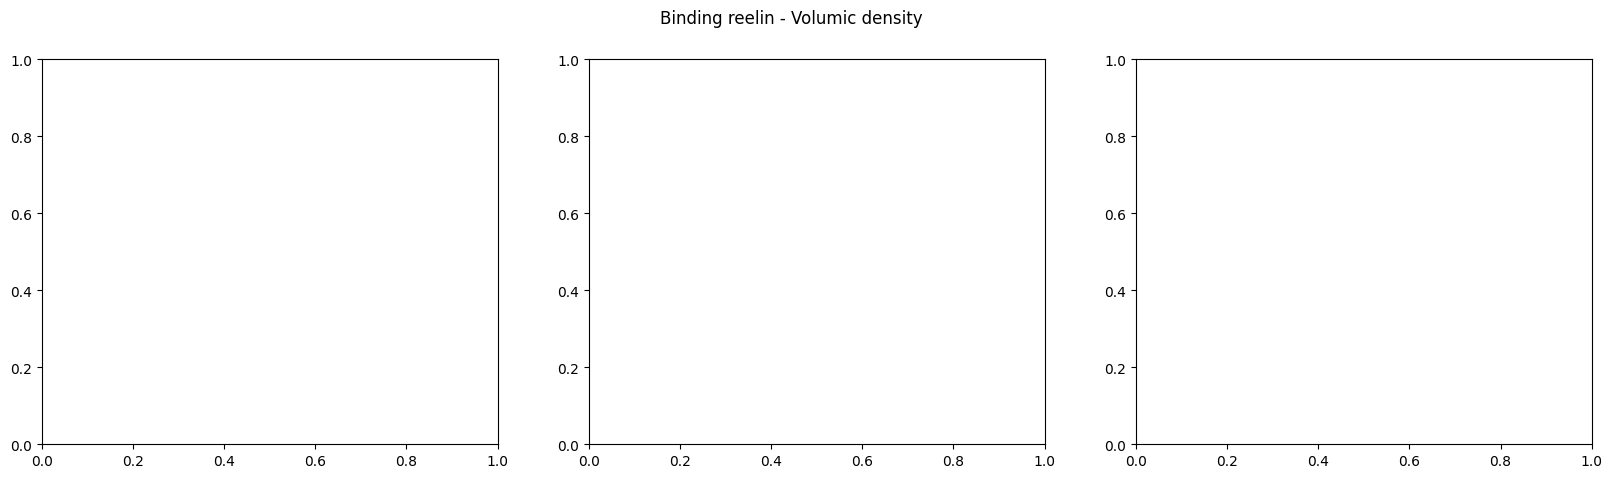

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Binding reelin - Volumic density')
sns.boxplot(layer1_b, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer1_b,
              ax=axes[0])
axes[0].set_title('Layer 1')
sns.boxplot(layer23_b, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer23_b,
              ax=axes[1])
axes[1].set_title('Layer 2 and 3')
sns.boxplot(layer56_b, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[2])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer56_b,
              ax=axes[2])
axes[2].set_title('Layer 5 and 6')

#### Bregma coordinates

In [178]:
fig910_b = b[(b['Figure']==9) | (b['Figure']==10)]
fig910_b = pd.DataFrame(fig910_b.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig910_b.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              49.073390
1  B10Mouse2SRWin     SRWin              47.761665
2    B10Mouse3Win       Win              28.112357
3  B10Mouse4SRWin     SRWin              33.169851
4    B10Mouse6Win       Win              27.044407

In [179]:
fig1112_b = b[(b['Figure']==11) | (b['Figure']==12)]
fig1112_b = pd.DataFrame(fig1112_b.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1112_b.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              38.473146
1  B10Mouse2SRWin     SRWin              36.996742
2  B10Mouse4SRWin     SRWin              30.496250
3    B10Mouse6Win       Win              33.865417
4   B2Mouse0Naive     Naive              18.084728

In [180]:
fig13_b = b[(b['Figure']==13) ]
fig13_b = pd.DataFrame(fig13_b.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig13_b.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              33.655021
1  B10Mouse2SRWin     SRWin              31.845400
2  B10Mouse4SRWin     SRWin              31.514328
3    B10Mouse6Win       Win              25.388996
4   B2Mouse0Naive     Naive              13.137873

In [181]:
fig1415_b = b[(b['Figure']==14) | (b['Figure']==15)]
fig1415_b = pd.DataFrame(fig1415_b.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1415_b.head()

ID Condition  volumic_density_total
0  B10Mouse1SRWin     SRWin              36.110315
1  B10Mouse2SRWin     SRWin              28.538131
2  B10Mouse4SRWin     SRWin              22.735507
3    B10Mouse6Win       Win              26.233762
4   B2Mouse0Naive     Naive              21.650792

Text(0.5, 1.0, 'Figure 14 and 15')

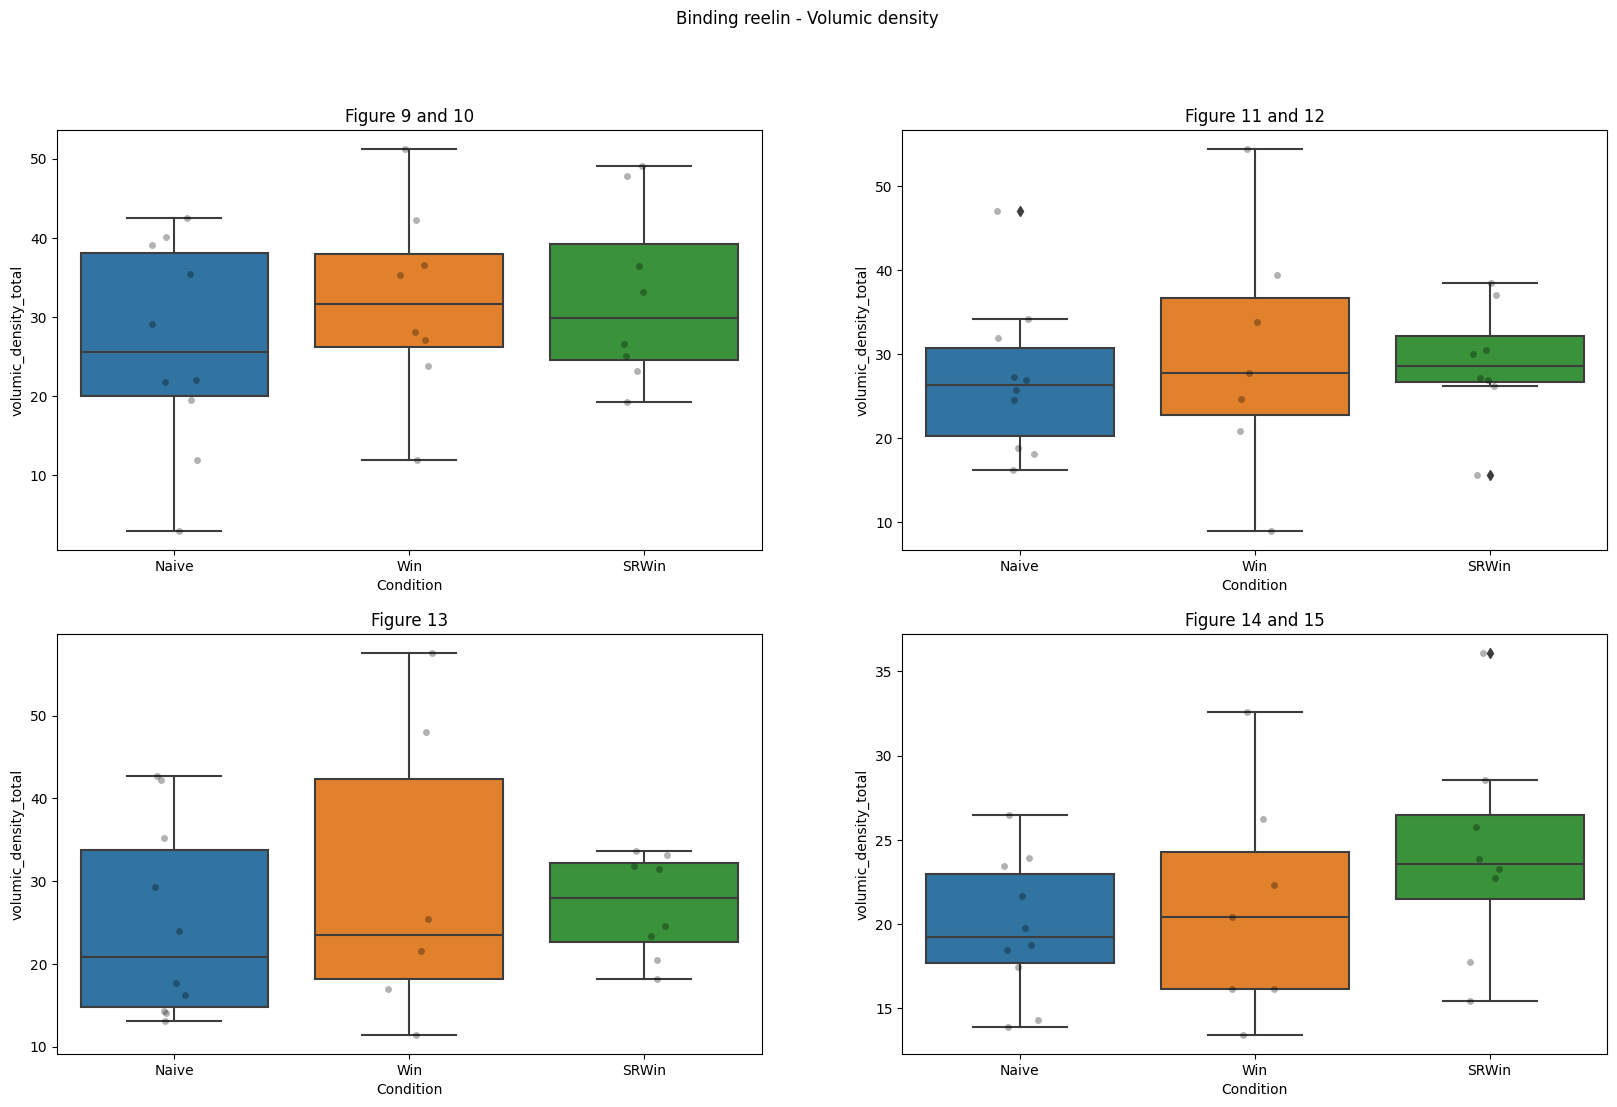

In [182]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle('Binding reelin - Volumic density')
sns.boxplot(fig910_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910_b,
              ax=axes[0, 0])
axes[0, 0].set_title('Figure 9 and 10')
sns.boxplot(fig1112_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112_b,
              ax=axes[0, 1])
axes[0,1].set_title('Figure 11 and 12')
sns.boxplot(fig13_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13_b,
              ax=axes[1, 0])
axes[1, 0].set_title('Figure 13')
sns.boxplot(fig1415_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415_b,
              ax=axes[1,1])
axes[1,1].set_title('Figure 14 and 15')

### Carefull : Without grouping by animal

Text(0.5, 1.0, 'Layer 5 and 6')

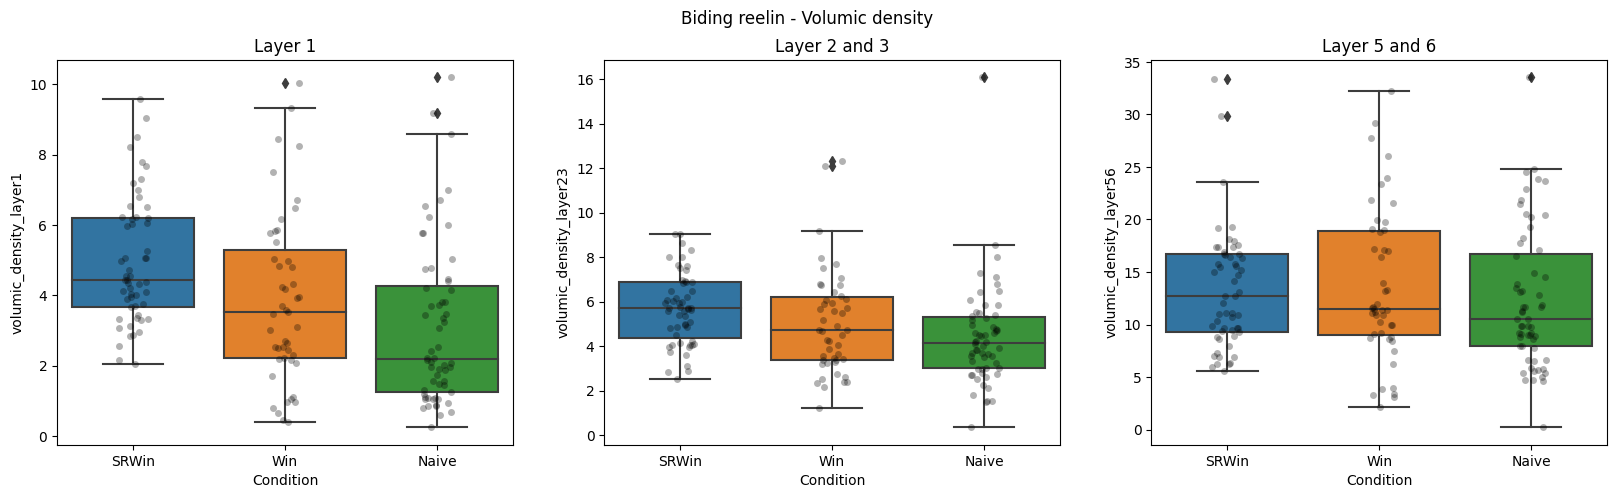

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Biding reelin - Volumic density')
sns.boxplot(b, y='volumic_density_layer1', x = 'Condition', ax=axes[0])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              color = 'black',
              alpha = 0.3,
              data = b,
              ax=axes[0])
axes[0].set_title('Layer 1')
sns.boxplot(b, y='volumic_density_layer23', x = 'Condition', ax=axes[1])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              color = 'black',
              alpha = 0.3,
              data = b,
              ax=axes[1])
axes[1].set_title('Layer 2 and 3')
sns.boxplot(b, y='volumic_density_layer56', x = 'Condition', ax=axes[2])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              color = 'black',
              alpha = 0.3,
              data = b,
              ax=axes[2])
axes[2].set_title('Layer 5 and 6')
# Add in points to show each observation




### Distance density

c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


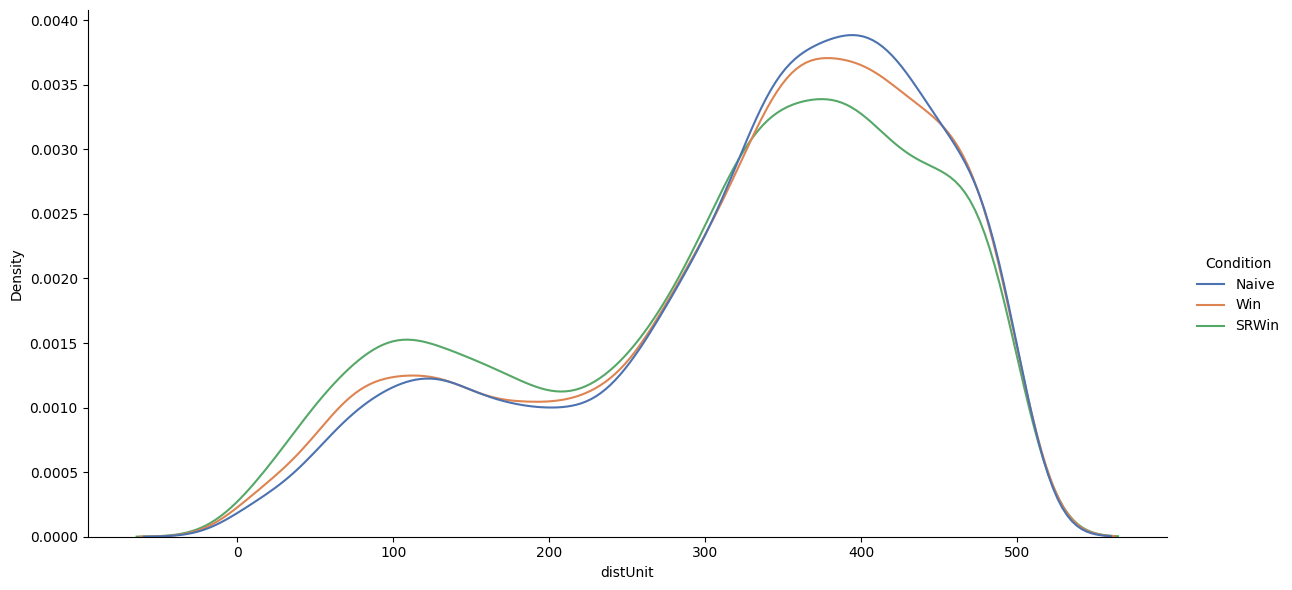

In [198]:
sns.displot(binding, x="distUnit", hue="Condition", kind = 'kde', palette = "deep",height=6, aspect=2, common_norm=False)


c:\Users\Thenzing\Julien\MasCambios\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


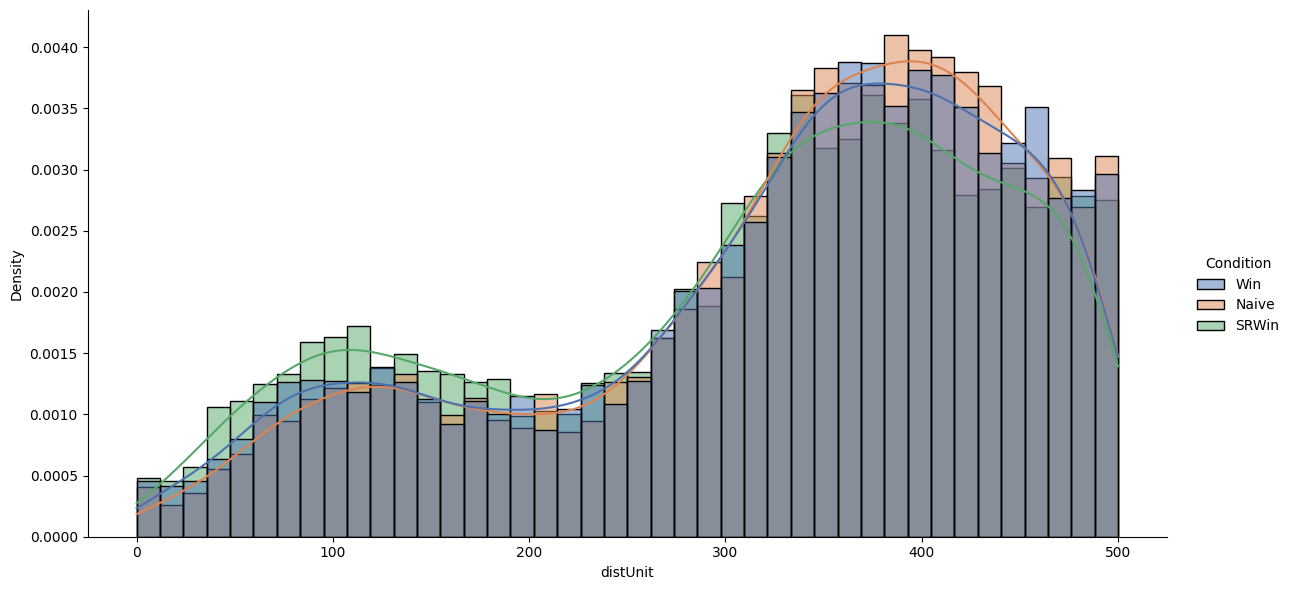

In [57]:
sns.displot(binding, x="distUnit", hue="Condition", stat = 'density', kde  =True, palette = "deep",height=6, aspect=2, common_norm=False)

### 3D PLots

In [36]:
naiveb, srwinb, winb = extract_conditions(binding)

In [37]:
displot_3D(naiveb, 'naive binding')

In [38]:
displot_3D(srwinb, 'srwin binding')

In [39]:
displot_3D(winb, 'win binding')

### Joint Plots

#### distance + intensity

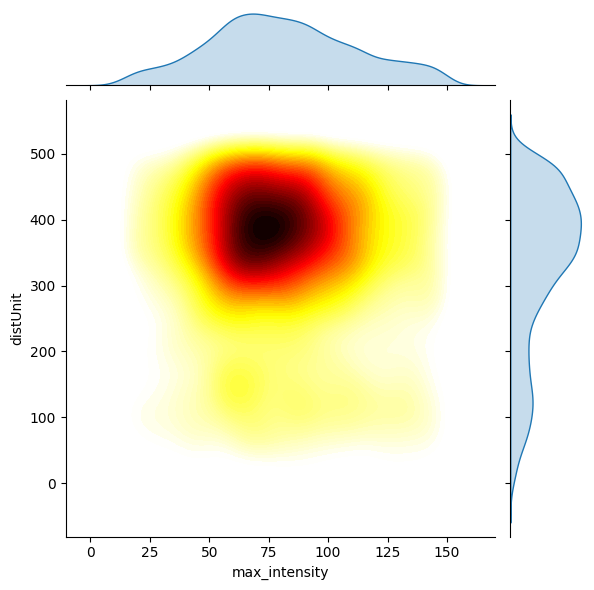

In [252]:
sns.jointplot(
    data=naiveb,
    x="max_intensity", y="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

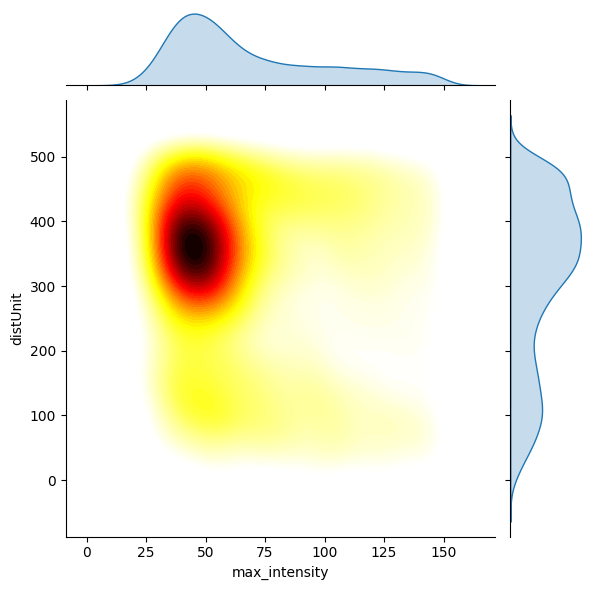

In [253]:
sns.jointplot(
    data=srwinb,
    x="max_intensity", y="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

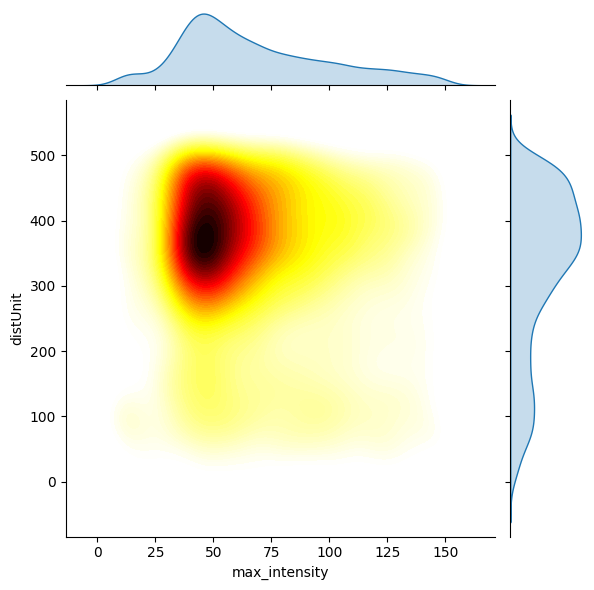

In [254]:
sns.jointplot(
    data=winb,
    x="max_intensity", y="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

#### rostrocaudal + distance 

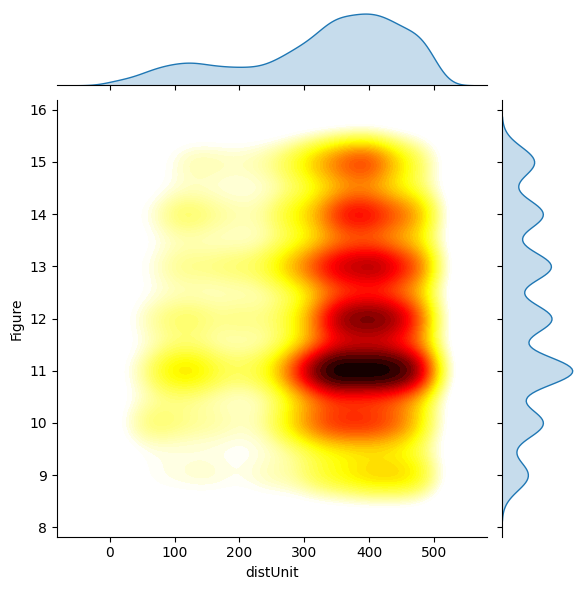

In [260]:
sns.jointplot(
    data=naiveb,
    y="Figure", x="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

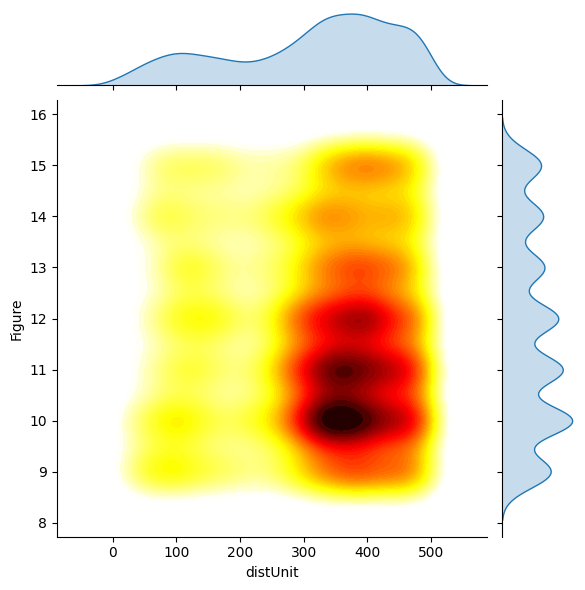

In [261]:
sns.jointplot(
    data=srwinb,
    y="Figure", x="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

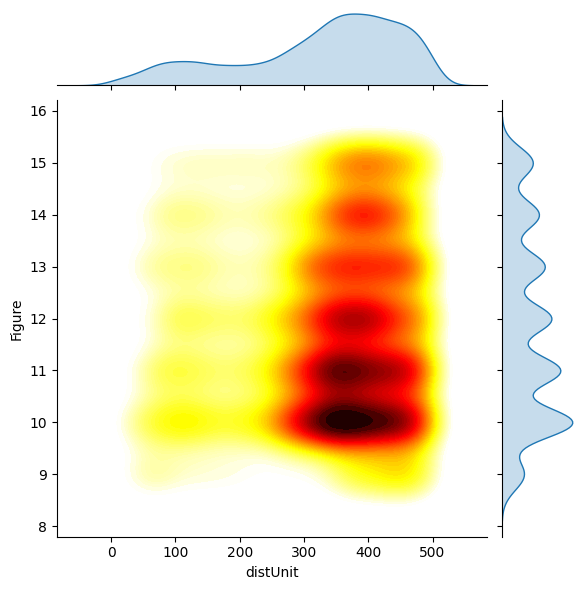

In [259]:
sns.jointplot(
    data=winb,
    y="Figure", x="distUnit",cmap='hot_r', n_levels=60,
    kind="kde",fill=True )

## Plots


In [31]:
fig = plt.figure(figsize=(10, 7))

<Figure size 1000x700 with 0 Axes>

In [32]:
(topfig, bottomfig) = fig.subfigures(2, 1)

topfig.set_facecolor('#cbe4c6ff')
topfig.suptitle('Top')

bottomfig.set_facecolor('#c6c8e4ff')
bottomfig.suptitle('Bottom')

Text(0.5, 0.98, 'Bottom')

In [38]:
top_axs = topfig.subplots(2, 4)
bottom_axs = bottomfig.subplots(3, 7)
data = sns.load_dataset('mpg')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('All cells - Volumic density')
sns.boxplot(layer1_a, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer1_a,
              ax=axes[0])
axes[0].set_title('Layer 1')
sns.boxplot(layer23_a, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer23_a,
              ax=axes[1])
axes[1].set_title('Layer 2 and 3')
sns.boxplot(layer56_a, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[2])
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = layer56_a,
              ax=axes[2])
axes[2].set_title('Layer 5 and 6')

In [21]:
def letter_annotation(ax, xoffset, yoffset, letter):
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=12, weight='bold')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SRWin v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=1.000e+00 U_stat=3.200e+01
Win v.s. Naive: Mann-Whitney-Wilcoxon test two-sided, P_val=7.618e-01 U_stat=4.400e+01
SRWin v.s. Naive: Mann-Whitney-Wilcoxon test two-sided, P_val=6.965e-01 U_stat=4.500e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SRWin v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=7.211e-02 U_stat=1.200e+01
Win v.s. Naive: Mann-Whitney-Wilcoxon test two-sided, P_val=4.173e-01 U_stat=2.600e+01
SRWin v.s. Naive: Mann-Whitney-Wilcoxon test two-sided, P_val=4.388e-03 U_stat=9.000e+00


C:\Windows\Temp\ipykernel_1252\2304132057.py:91: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  bottomfig.subplots_adjust(wspace=0.9, left=0, right=1, bottom=.16)


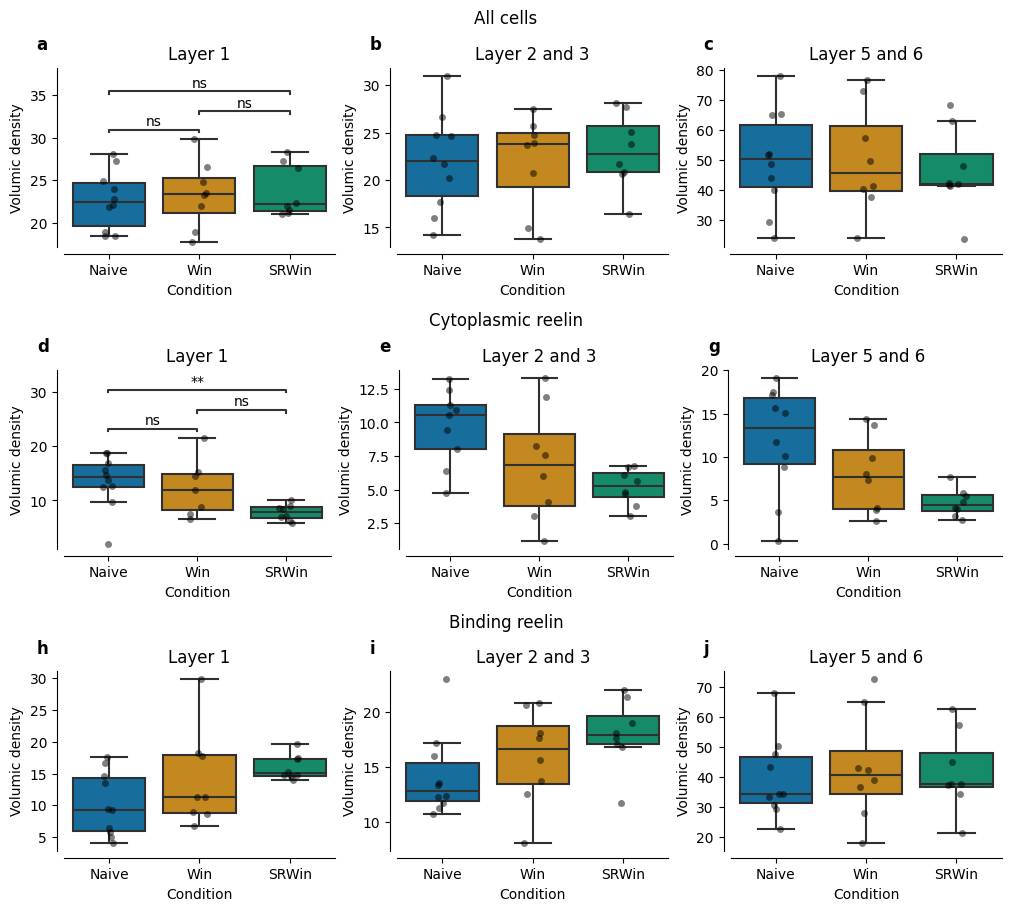

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(10, 9))


boxp =[("SRWin", "Win"), ("SRWin", "Naive"),("Win", "Naive")]
# create 3x1 subfigs
(topfig, midfig, bottomfig) = fig.subfigures(3, 1)
top_axes = topfig.subplots(1, 3)

topfig.suptitle('All cells')
a = sns.boxplot(layer1_a, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=top_axes[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition", y = "volumic_density_layer1", order = ['Naive', 'Win', 'SRWin'], color = 'black', alpha = 0.5, data = layer1_a, ax=top_axes[0]).set(xlabel='Condition', ylabel = 'Volumic density')
top_axes[0].set_title('Layer 1')
letter_annotation(top_axes[0], -0.1, 1.1, 'a')
sns.despine(offset=5, trim=False, ax=top_axes[0])
add_stat_annotation(a, data=layer1_a, x="Condition", y='volumic_density_layer1', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

sns.boxplot(layer23_a, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=top_axes[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer23_a,
              ax=top_axes[1]).set(xlabel='Condition', ylabel = 'Volumic density')
top_axes[1].set_title('Layer 2 and 3')
sns.despine(offset=5, trim=False, ax=top_axes[1])

letter_annotation(top_axes[1], -0.1, 1.1, 'b')
sns.boxplot(layer56_a, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=top_axes[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer56_a,
              ax=top_axes[2]).set(xlabel='Condition', ylabel = 'Volumic density')
top_axes[2].set_title('Layer 5 and 6')
letter_annotation(top_axes[2], -0.1, 1.1, 'c')
sns.despine(offset=5, trim=False, ax=top_axes[2])


mid_axes = midfig.subplots(1, 3)
midfig.suptitle('Cytoplasmic reelin')
d = sns.boxplot(layer1_c, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=mid_axes[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer1_c,
              ax=mid_axes[0]).set(xlabel='Condition', ylabel = 'Volumic density')
mid_axes[0].set_title('Layer 1')
letter_annotation(mid_axes[0], -0.1, 1.1, 'd')
sns.despine(offset=5, trim=False, ax=mid_axes[0])
add_stat_annotation(d, data=layer1_c, x="Condition", y='volumic_density_layer1', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
sns.boxplot(layer23_c, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=mid_axes[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer23_c,
              ax=mid_axes[1]).set(xlabel='Condition', ylabel = 'Volumic density')
mid_axes[1].set_title('Layer 2 and 3')
letter_annotation(mid_axes[1], -0.1, 1.1, 'e')
sns.despine(offset=5, trim=False, ax=mid_axes[1])

sns.boxplot(layer56_c, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=mid_axes[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer56_c,
              ax=mid_axes[2]).set(xlabel='Condition', ylabel = 'Volumic density')
mid_axes[2].set_title('Layer 5 and 6')
letter_annotation(mid_axes[2], -0.1, 1.1, 'g')
sns.despine(offset=5, trim=False, ax=mid_axes[2])



bottom_axes = bottomfig.subplots(1, 3)
bottomfig.subplots_adjust(wspace=0.9, left=0, right=1, bottom=.16)

bottomfig.suptitle('Binding reelin')
sns.boxplot(layer1_b, y='volumic_density_layer1', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=bottom_axes[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer1",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer1_b,
              ax=bottom_axes[0]).set(xlabel='Condition', ylabel = 'Volumic density')
bottom_axes[0].set_title('Layer 1')
sns.despine(offset=5, trim=False, ax=bottom_axes[0])
letter_annotation(bottom_axes[0], -0.1, 1.1, 'h')

sns.boxplot(layer23_b, y='volumic_density_layer23', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=bottom_axes[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer23",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer23_b,
              ax=bottom_axes[1]).set(xlabel='Condition', ylabel = 'Volumic density')
bottom_axes[1].set_title('Layer 2 and 3')
sns.despine(offset=5, trim=False, ax=bottom_axes[1])
letter_annotation(bottom_axes[1], -0.1, 1.1, 'i')

sns.boxplot(layer56_b, y='volumic_density_layer56', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=bottom_axes[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_layer56",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = layer56_b,
              ax=bottom_axes[2]).set(xlabel='Condition', ylabel = 'Volumic density')
bottom_axes[2].set_title('Layer 5 and 6')
sns.despine(offset=5, trim=False, ax=bottom_axes[2])
letter_annotation(bottom_axes[2], -0.1, 1.1, 'j')

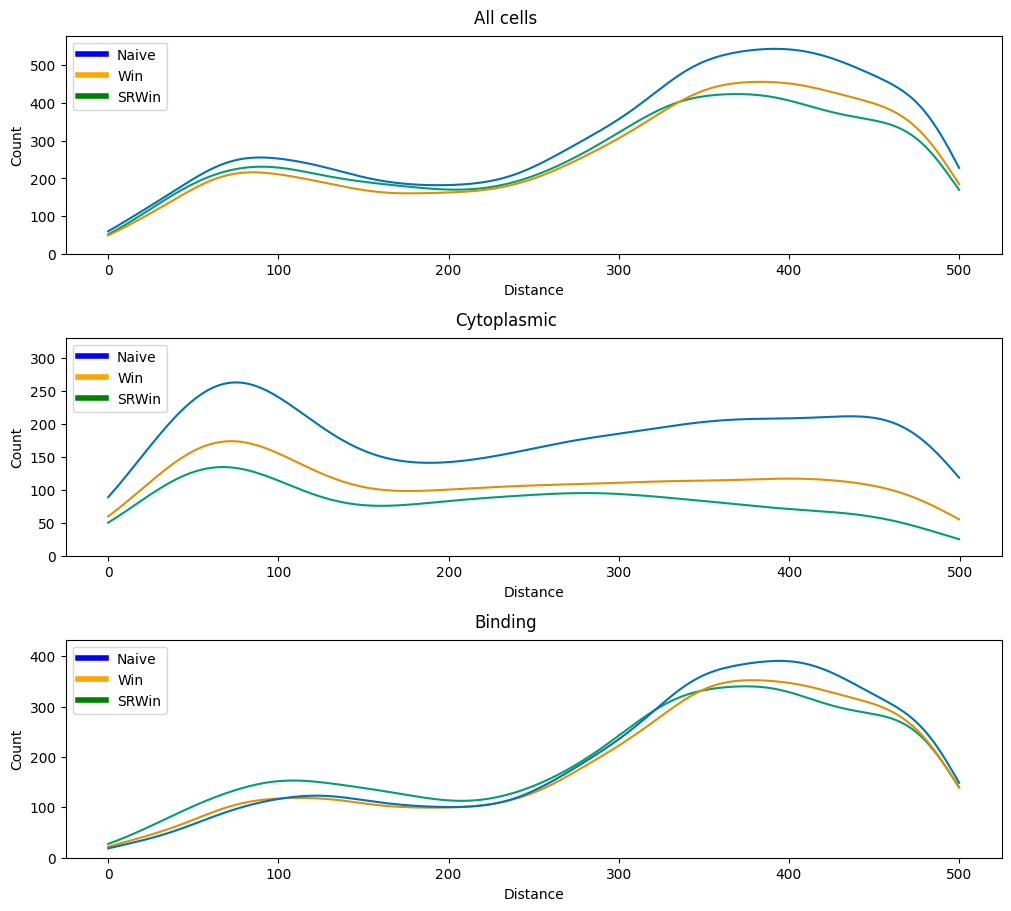

In [176]:
fig = plt.figure(constrained_layout=True, figsize=(10, 9))

# create 3x1 subfigs
(topfig, midfig, bottomfig) = fig.subfigures(3, 1)
top_ax = topfig.subplots(1, 1)
mid_ax = midfig.subplots(1, 1)
bottom_ax = bottomfig.subplots(1, 1)
#sns.displot(data = cytoplasmic, x="distUnit", hue="Condition", kind = 'kde', palette = "colorblind",height=6, aspect=2, common_norm=False, ax = mid_ax[0]).set(title='Cytoplasmic reelin layer distribution',xlabel ="Distance (µm)", ylabel = "Density")
topfig.suptitle("All cells")
sns.histplot(data = df, x="distUnit", hue="Condition", kde = True, common_norm=False, palette = 'colorblind', color='white', edgecolor='white', alpha=0, ax= top_ax).set(xlabel = "Distance")
top_ax.legend(handles=legend_elements, loc='upper left')
midfig.suptitle("Cytoplasmic")
sns.histplot(data = cytoplasmic, x="distUnit", hue="Condition", kde = True, common_norm=False, palette = 'colorblind', color='white', edgecolor='white', alpha=0, ax = mid_ax).set(xlabel = "Distance")
mid_ax.legend(handles=legend_elements, loc='upper left')
bottomfig.suptitle("Binding")
sns.histplot(data = binding, x="distUnit", hue="Condition", kde = True, common_norm=False, palette = 'colorblind', color='white', edgecolor='white', alpha=0, ax= bottom_ax).set(xlabel = "Distance")
bottom_ax.legend(handles=legend_elements, loc='upper left')


Text(0.5, 1.0, 'Figure 14 and 15')

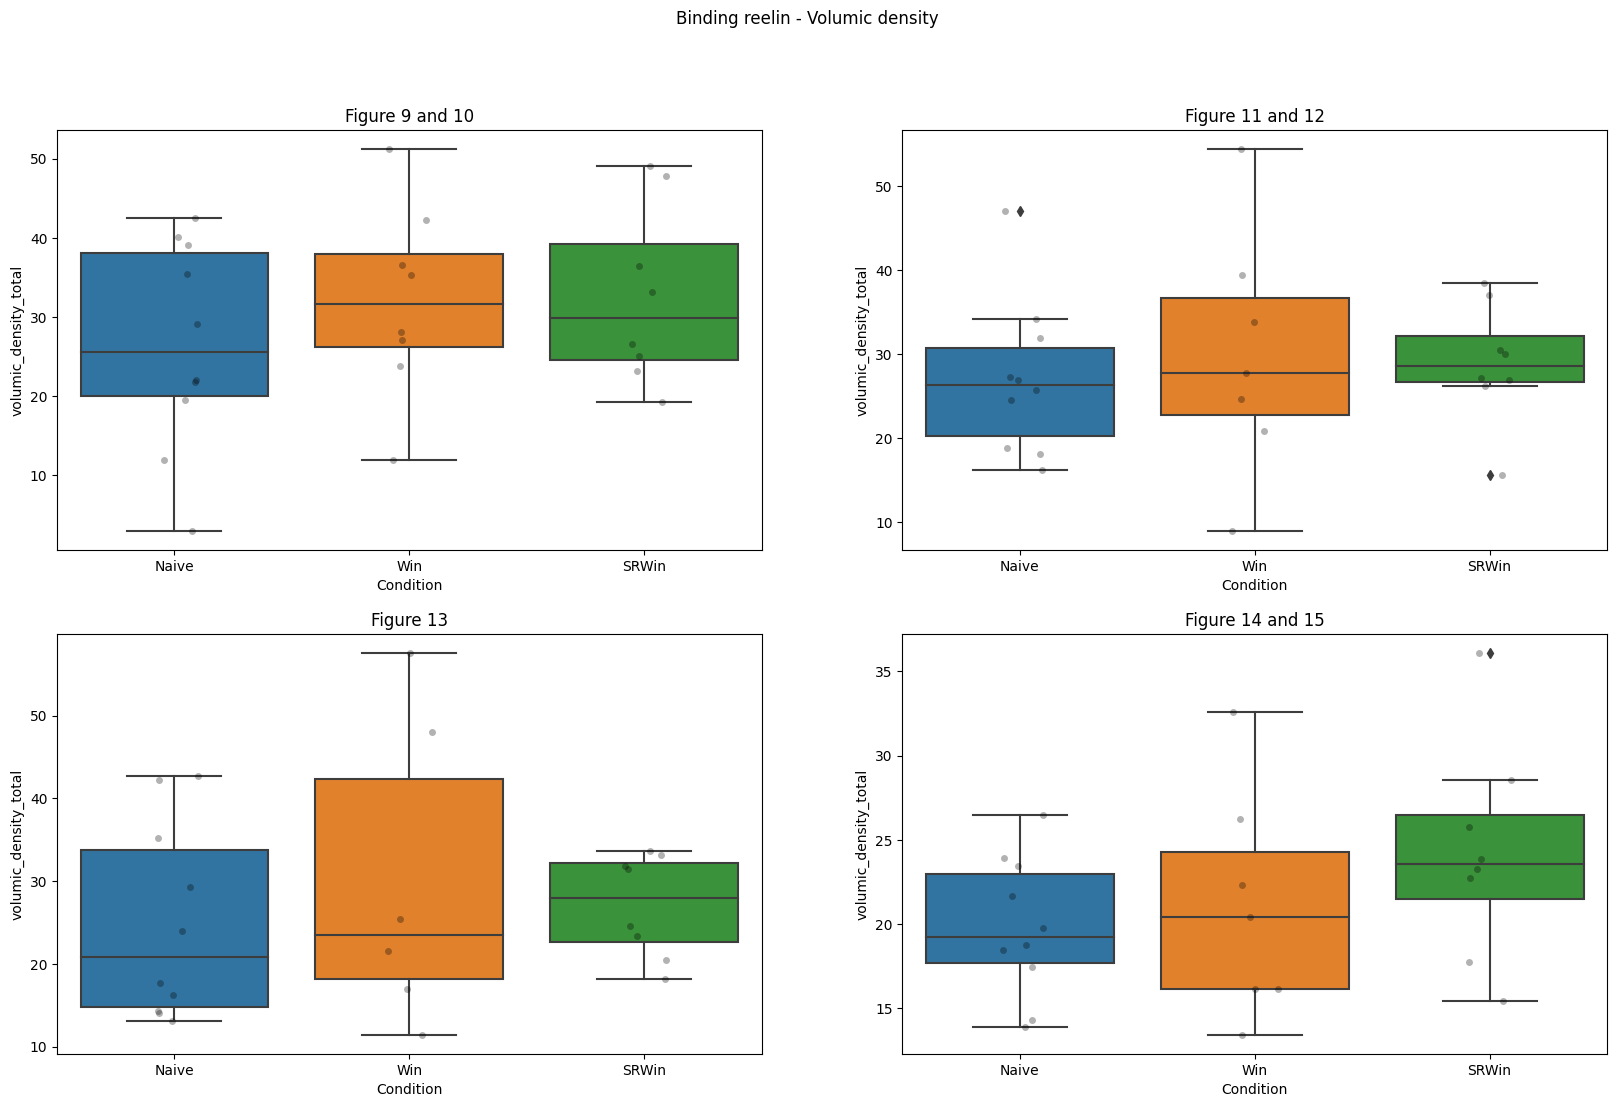

In [183]:
fig = plt.figure(constrained_layout=True, figsize=(10, 9))

# create 3x1 subfigs
subfigs = fig.subfigures(1, 4)



plt.suptitle('Binding reelin - Volumic density')
sns.boxplot(fig910_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910_b,
              ax=axes[0, 0])
axes[0, 0].set_title('Figure 9 and 10')
sns.boxplot(fig1112_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112_b,
              ax=axes[0, 1])
axes[0,1].set_title('Figure 11 and 12')
sns.boxplot(fig13_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13_b,
              ax=axes[1, 0])
axes[1, 0].set_title('Figure 13')
sns.boxplot(fig1415_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415_b,
              ax=axes[1,1])
axes[1,1].set_title('Figure 14 and 15')

Text(0.5, 1.0, 'Figure 14 and 15')

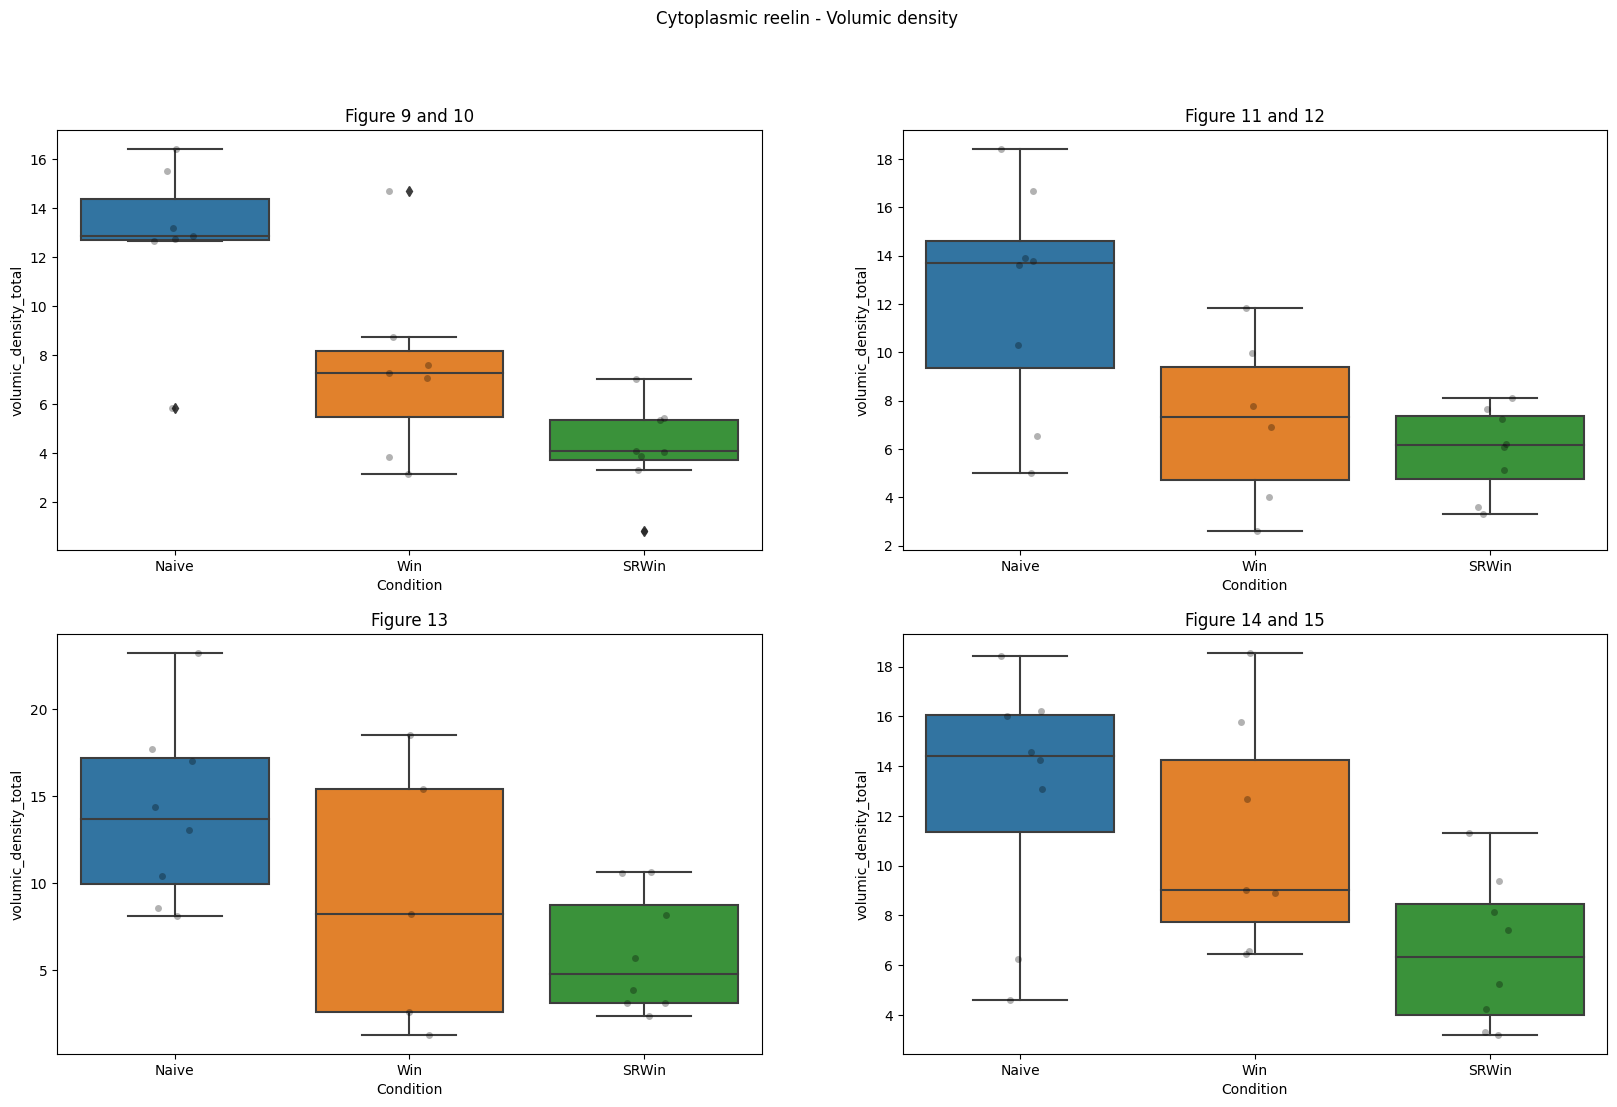

In [207]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle('Cytoplasmic reelin - Volumic density')
sns.boxplot(fig910, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910,
              ax=axes[0, 0])
axes[0, 0].set_title('Figure 9 and 10')
sns.boxplot(fig1112, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112,
              ax=axes[0, 1])
axes[0,1].set_title('Figure 11 and 12')
sns.boxplot(fig13, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13,
              ax=axes[1, 0])
axes[1, 0].set_title('Figure 13')
sns.boxplot(fig1415, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415,
              ax=axes[1,1])
axes[1,1].set_title('Figure 14 and 15')

Text(0.5, 1.0, 'Figure 14 and 15')

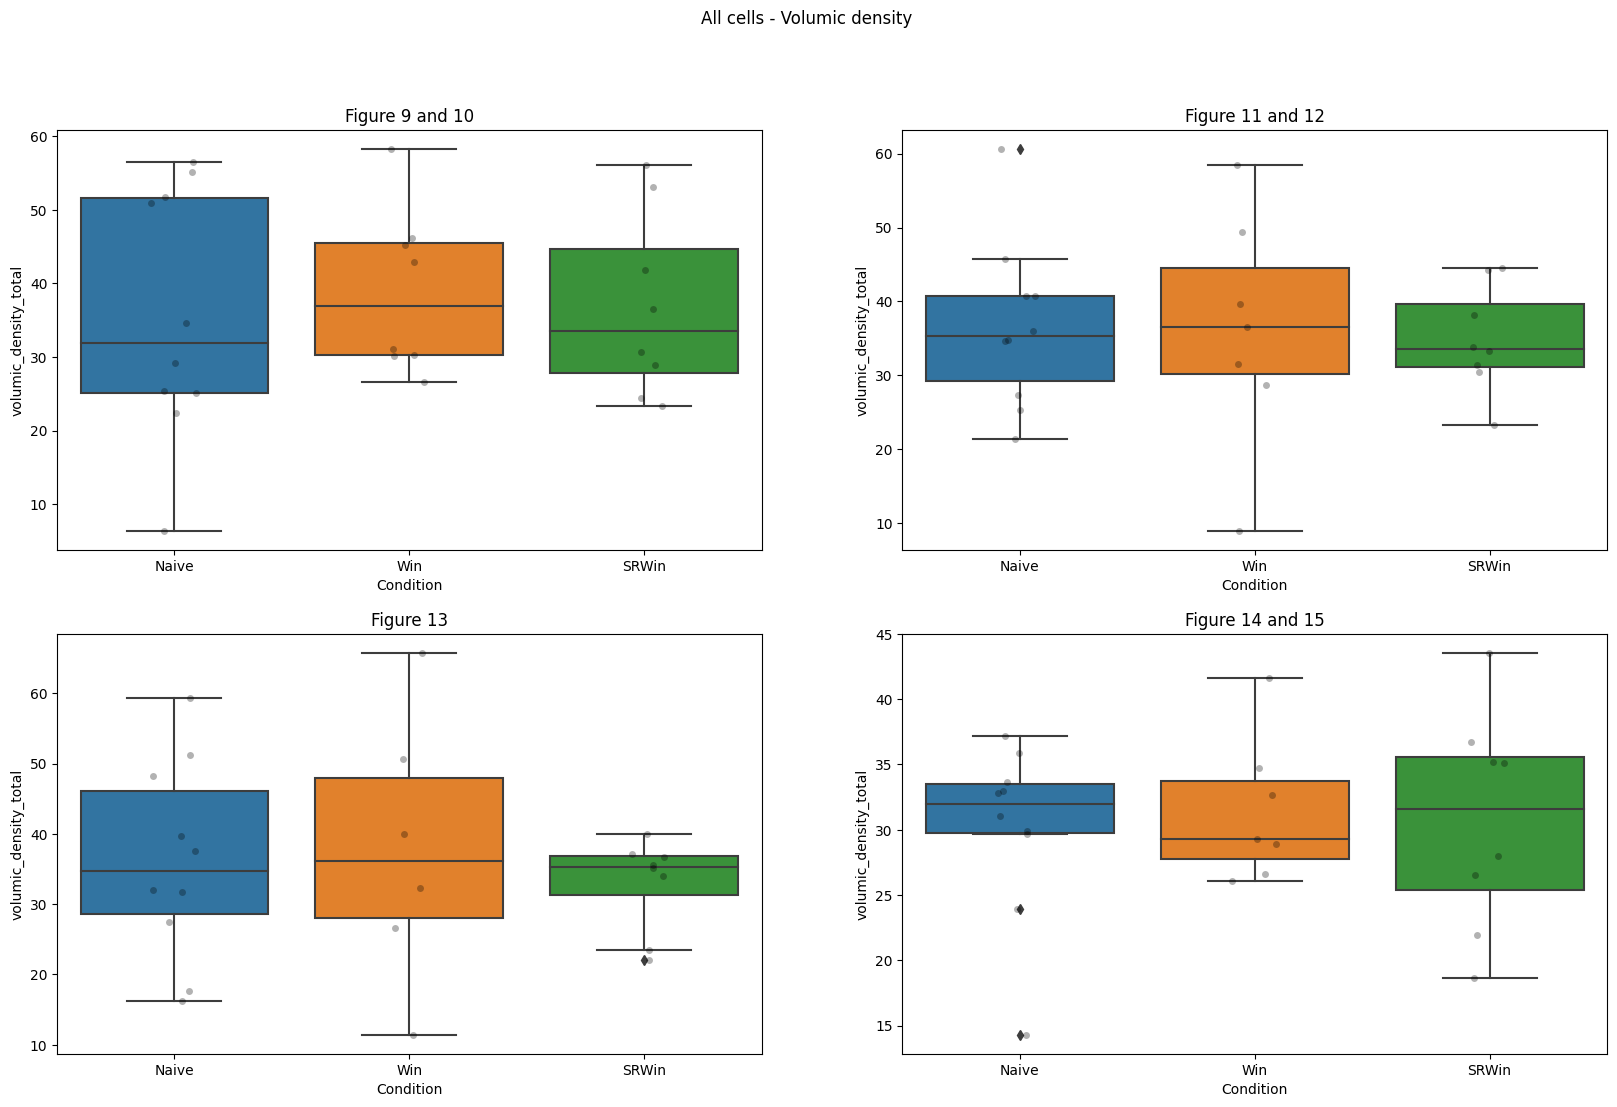

In [208]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle('All cells - Volumic density')
sns.boxplot(fig910_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910_a,
              ax=axes[0, 0])
axes[0, 0].set_title('Figure 9 and 10')
sns.boxplot(fig1112_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[0, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112_a,
              ax=axes[0, 1])
axes[0,1].set_title('Figure 11 and 12')
sns.boxplot(fig13_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 0])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13_a,
              ax=axes[1, 0])
axes[1, 0].set_title('Figure 13')
sns.boxplot(fig1415_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=axes[1, 1])
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415_a,
              ax=axes[1,1])
axes[1,1].set_title('Figure 14 and 15')

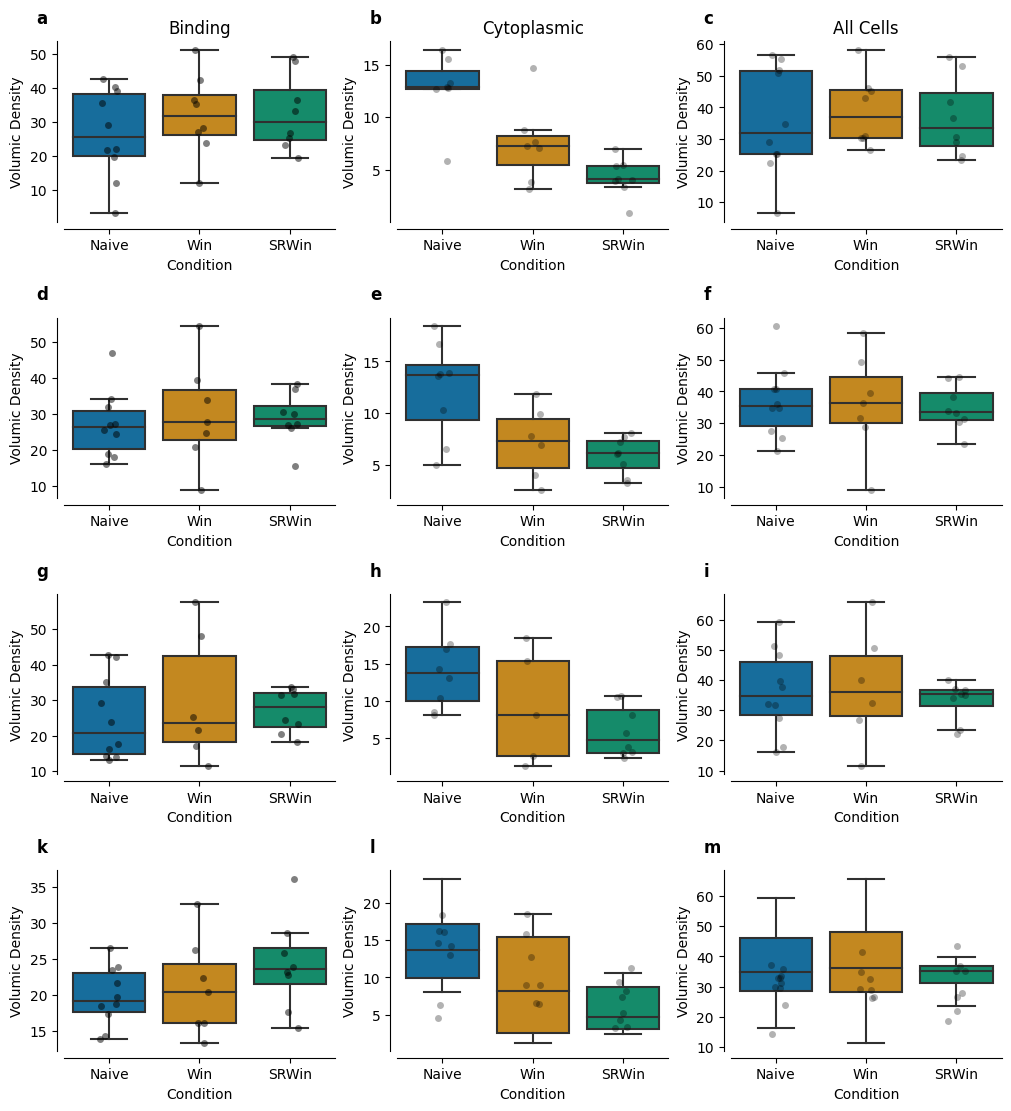

In [226]:
fig = plt.figure(constrained_layout=True, figsize=(10, 11))

# create 3x1 subfigs
(row1, row2, row3, row4) = fig.subfigures(4, 1)

ax1 = row1.subplots(1, 3)

sns.boxplot(fig910_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax1[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = fig910_b,
              ax=ax1[0]).set(title= "Binding",ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax1[0])
letter_annotation(ax1[0], -0.1, 1.1, 'a')
sns.boxplot(fig910, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax1[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910,
              ax=ax1[1]).set(title= "Cytoplasmic", ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax1[1])
letter_annotation(ax1[1], -0.1, 1.1, 'b')
sns.boxplot(fig910_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax1[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig910_a,
              ax=ax1[2]).set(title= "All Cells", ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax1[2])
letter_annotation(ax1[2], -0.1, 1.1, 'c')

ax2 = row2.subplots(1, 3)

sns.boxplot(fig1112_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax2[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = fig1112_b,
              ax=ax2[0]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax2[0])
letter_annotation(ax2[0], -0.1, 1.1, 'd')
sns.boxplot(fig1112, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax2[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112,
              ax=ax2[1]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax2[1])
letter_annotation(ax2[1], -0.1, 1.1, 'e')
sns.boxplot(fig1112_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax2[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1112_a,
              ax=ax2[2]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax2[2])
letter_annotation(ax2[2], -0.1, 1.1, 'f')
ax3 = row3.subplots(1, 3)
sns.boxplot(fig13_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax3[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = fig13_b,
              ax=ax3[0]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax3[0])
letter_annotation(ax3[0], -0.1, 1.1, 'g')
sns.boxplot(fig13, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax3[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13,
              ax=ax3[1]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax3[1])
letter_annotation(ax3[1], -0.1, 1.1, 'h')
sns.boxplot(fig13_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax3[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig13_a,
              ax=ax3[2]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax3[2])
letter_annotation(ax3[2], -0.1, 1.1, 'i')

ax4 = row4.subplots(1, 3)
sns.boxplot(fig1415_b, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax4[0], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.5,
              data = fig1415_b,
              ax=ax4[0]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax4[0])
letter_annotation(ax4[0], -0.1, 1.1, 'k')
sns.boxplot(fig13, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax4[1], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415,
              ax=ax4[1]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax4[1])
letter_annotation(ax4[1], -0.1, 1.1, 'l')
sns.boxplot(fig13_a, y='volumic_density_total', x = 'Condition', order = ['Naive', 'Win', 'SRWin'], ax=ax4[2], showfliers = False, palette = 'colorblind')
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              order = ['Naive', 'Win', 'SRWin'],
              color = 'black',
              alpha = 0.3,
              data = fig1415_a,
              ax=ax4[2]).set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False, ax=ax4[2])
letter_annotation(ax4[2], -0.1, 1.1, 'm')